In [ ]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Models: ANN, ELM, SVR, KRR, RF, XGB
from sklearn.neural_network import MLPRegressor
from skelm import ELMRegressor
from sklearn.svm import SVR
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

import optuna
import shap

import warnings
warnings.filterwarnings('ignore')

Import the data

In [ ]:
rawdata = pd.read_excel("data.xlsx")

In [ ]:
rawdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 552 entries, 0 to 551
Data columns (total 20 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   G2B         552 non-null    int64  
 1   Batt Store  552 non-null    int64  
 2   B2G         552 non-null    int64  
 3   PP1         552 non-null    int64  
 4   Nuclear     552 non-null    int64  
 5   Wind        552 non-null    int64  
 6   PV          552 non-null    int64  
 7   RH          552 non-null    int64  
 8   CSP         552 non-null    int64  
 9   ES1 Ch      552 non-null    int64  
 10  ES1 Disch   552 non-null    int64  
 11  ES1 Store   552 non-null    int64  
 12  ES2 Ch      552 non-null    int64  
 13  ES2 Disch   552 non-null    int64  
 14  ES2 Store   552 non-null    int64  
 15  Total Cost  552 non-null    int64  
 16  CO2         552 non-null    float64
 17  CEEP        552 non-null    float64
 18  Import      552 non-null    float64
 19  Export      552 non-null    f

In [ ]:
rawdata.describe()

,G2B,Batt Store,B2G,PP1,Nuclear,Wind,PV,RH,CSP,ES1 Ch,ES1 Disch,ES1 Store,ES2 Ch,ES2 Disch,ES2 Store,Total Cost,CO2,CEEP,Import,Export
count,552.000000,552.000000,552.000000,552.000000,552.000000,552.000000,552.000000,552.000000,552.000000,552.000000,552.000000,552.000000,552.000000,552.000000,552.000000,552.000000,552.000000,552.000000,552.000000,552.000000
mean,27850.000000,30.000000,27500.000000,100000.000000,15000.000000,7500.000000,100000.000000,10000.000000,25000.000000,65000.000000,65000.000000,5000.000000,65000.000000,65000.000000,5000.000000,158771.396739,349.738013,12.381902,139.606322,15.302446
std,21352.139284,19.279584,21689.532004,48198.960009,14459.688003,7229.844001,96397.920017,9639.792002,24099.480004,33739.272006,33739.272006,4819.896001,33739.272006,33739.272006,4819.896001,32031.488323,94.044064,19.857113,163.512076,22.021346
min,5700.000000,10.000000,5000.000000,50000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,30000.000000,30000.000000,0.000000,30000.000000,30000.000000,0.000000,101178.000000,219.984000,0.000000,0.000000,0.000000
25%,5700.000000,10.000000,5000.000000,50000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,30000.000000,30000.000000,0.000000,30000.000000,30000.000000,0.000000,137241.500000,272.474250,0.000000,0.030000,0.000000
50%,27850.000000,30.000000,27500.000000,100000.000000,15000.000000,7500.000000,100000.000000,10000.000000,25000.000000,65000.000000,65000.000000,5000.000000,65000.000000,65000.000000,5000.000000,157584.500000,320.898000,0.000000,39.990000,2.240000
75%,50000.000000,50.000000,50000.000000,150000.000000,30000.000000,15000.000000,200000.000000,20000.000000,50000.000000,100000.000000,100000.000000,10000.000000,100000.000000,100000.000000,10000.000000,180934.500000,410.026000,19.385000,250.277500,25.430000
max,50000.000000,50.000000,50000.000000,150000.000000,30000.000000,15000.000000,200000.000000,20000.000000,50000.000000,100000.000000,100000.000000,10000.000000,100000.000000,100000.000000,10000.000000,256198.000000,556.268000,79.070000,506.800000,86.200000


In [ ]:
import random

def fixed_randomization(data):
    np.random.seed(42) 
    rand_data = data.sample(frac=1).reset_index(drop=True)
    return rand_data

rand_data = fixed_randomization(rawdata)

In [ ]:
rand_data.head(10)

,G2B,Batt Store,B2G,PP1,Nuclear,Wind,PV,RH,CSP,ES1 Ch,ES1 Disch,ES1 Store,ES2 Ch,ES2 Disch,ES2 Store,Total Cost,CO2,CEEP,Import,Export
0,27850,30,27500,100000,15000,7500,100000,10000,25000,65000,65000,5000,65000,65000,5000,141154,396.377,0.00,39.99,2.24
1,50000,10,5000,50000,30000,0,200000,0,0,30000,30000,10000,100000,100000,10000,156859,245.717,0.62,204.30,5.37
2,5700,10,50000,150000,0,0,0,20000,0,30000,100000,0,30000,100000,10000,114299,517.183,0.00,0.08,0.00
3,50000,50,50000,150000,0,0,200000,0,0,30000,30000,10000,100000,30000,10000,126188,486.352,0.54,1.96,5.44
4,5700,10,5000,50000,30000,0,0,0,50000,100000,30000,0,100000,30000,0,185909,273.581,0.00,246.25,0.00
5,5700,10,5000,150000,0,15000,200000,0,50000,100000,30000,0,100000,30000,0,158874,486.833,70.34,0.89,76.76
6,50000,50,50000,150000,0,15000,200000,20000,50000,30000,100000,10000,100000,30000,0,159197,440.122,50.03,0.03,57.40
7,50000,50,50000,150000,30000,0,200000,20000,50000,100000,30000,0,30000,100000,0,158644,332.122,66.21,0.00,73.25
8,5700,50,5000,50000,30000,0,200000,0,0,30000,30000,10000,30000,30000,10000,157432,249.986,10.44,205.44,15.19
9,50000,10,5000,150000,0,15000,200000,0,50000,30000,100000,10000,30000,100000,10000,170602,470.152,32.08,0.89,38.57


In [ ]:
X_data_unscale = rand_data[rand_data.columns[0:15]]
Y_data_unscale = rand_data[rand_data.columns[15:20]]

Y_data = Y_data_unscale

In [ ]:
SS = StandardScaler()
MMS = MinMaxScaler()
X_data = SS.fit_transform(X_data_unscale)
X_data = pd.DataFrame(X_data)

In [ ]:
X_data.head(5)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,1.038308,-1.038308,-1.038308,-1.038308,1.038308,-1.038308,1.038308,-1.038308,-1.038308,-1.038308,-1.038308,1.038308,1.038308,1.038308,1.038308
2,-1.038308,-1.038308,1.038308,1.038308,-1.038308,-1.038308,-1.038308,1.038308,-1.038308,-1.038308,1.038308,-1.038308,-1.038308,1.038308,1.038308
3,1.038308,1.038308,1.038308,1.038308,-1.038308,-1.038308,1.038308,-1.038308,-1.038308,-1.038308,-1.038308,1.038308,1.038308,-1.038308,1.038308
4,-1.038308,-1.038308,-1.038308,-1.038308,1.038308,-1.038308,-1.038308,-1.038308,1.038308,1.038308,-1.038308,-1.038308,1.038308,-1.038308,-1.038308


In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X_data, Y_data, test_size=0.3, random_state=42)

In [ ]:
y1_data = Y_data[Y_data.columns[0:1]]
y2_data = Y_data[Y_data.columns[1:2]]
y3_data = Y_data[Y_data.columns[2:3]]
y4_data = Y_data[Y_data.columns[3:4]]
y5_data = Y_data[Y_data.columns[4:5]]


y1_train = Y_train[Y_train.columns[0:1]]
y2_train = Y_train[Y_train.columns[1:2]]
y3_train = Y_train[Y_train.columns[2:3]]
y4_train = Y_train[Y_train.columns[3:4]]
y5_train = Y_train[Y_train.columns[4:5]]


y1_test = Y_test[Y_test.columns[0:1]]
y2_test = Y_test[Y_test.columns[1:2]]
y3_test = Y_test[Y_test.columns[2:3]]
y4_test = Y_test[Y_test.columns[3:4]]
y5_test = Y_test[Y_test.columns[4:5]]

In [ ]:
Y_test.describe()

,Total Cost,CO2,CEEP,Import,Export
count,166.000000,166.000000,166.000000,166.000000,166.000000
mean,154524.289157,355.873416,13.446566,120.898976,16.480663
std,30774.333493,94.996357,20.775806,157.757761,22.966645
min,101178.000000,219.984000,0.000000,0.000000,0.000000
25%,128066.500000,273.427250,0.000000,0.000000,0.000000
50%,153160.000000,346.894000,0.000000,2.050000,2.240000
75%,177334.500000,431.076250,21.002500,204.542500,26.502500
max,228006.000000,556.268000,78.440000,506.800000,85.580000


Metrics Function

In [ ]:
import pandas as pd
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np

def calculate_metrics(y_true, y_pred):
    # Extract values from DataFrames
    y_true_values = y_true.values.flatten()
    y_pred_values = y_pred.values.flatten()
    
    # R2 score
    r2 = r2_score(y_true_values, y_pred_values)
    r2 = round(r2, 4)
    
    # Mean Squared Error (MSE)
    mse = mean_squared_error(y_true_values, y_pred_values)
    mse = round(mse, 4)
    
    # Root Mean Squared Error (RMSE)
    rmse = np.sqrt(mse)
    rmse = round(rmse, 4)

    # Average Absolute Deviation (AAD)
    aad = np.mean(np.abs(y_true_values - y_pred_values))
    aad = round(aad, 4)
    
    # Squared Error Percentage (SEP)
    sep = np.mean(((y_true_values - y_pred_values) / y_true_values)**2) * 100
    sep = round(sep, 4)
    
    # Mean Absolute Error (MAE)
    mae = mean_absolute_error(y_true_values, y_pred_values)
    mae = round(mae, 4)
    
    '''print('r2: ', r2)
    print('mse: ', mse)
    print('rmse: ', rmse)
    print('aad: ', aad)
    print('sep: ', sep)
    print('mae: ', mae)'''   

    print(r2)
    print(mse)
    print(rmse)
    print(aad)
    print(sep)
    print(mae) 

# Random Forest

Y1

In [ ]:

y_data = y1_data
y_train = y1_train
y_test = y1_test


rf_model = RandomForestRegressor(random_state=24)
rf_model.fit(X_train, y_train)

y_train_pred = rf_model.predict(X_train)
train_r2 = r2_score(y_train, y_train_pred)

y_pred = rf_model.predict(X_test)
test_r2 = r2_score(y_test, y_pred)

y_data_pred = rf_model.predict(X_data)
data_r2 = r2_score(y_data, y_data_pred)

print('Train R_sq:', train_r2)
print('Test R_sq:', test_r2)
print('Data R_sq:', data_r2)

y_data_pred = pd.DataFrame(y_data_pred)
y_data = pd.DataFrame(y_data)
calculate_metrics(y_data, y_data_pred)

Train R_sq: 0.994073728910044
Test R_sq: 0.9787557414200696
Data R_sq: 0.9898845548666618
0.9899
10359809.1927
3218.6657
1438.9978
0.0376
1438.9978


## With Cross Val

In [ ]:
def objective(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 10, 100),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 64),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 32),
        'min_impurity_decrease': trial.suggest_float('min_impurity_decrease', 0.0, 20.0),
    }

    model = RandomForestRegressor(**param)
    score = cross_val_score(model, X_train, y_train, cv=10, scoring='r2').mean()
    return score

study = optuna.create_study(direction='maximize', study_name='regression')
study.optimize(objective, n_trials=100)


[I 2024-05-03 13:14:17,985] A new study created in memory with name: regression
[I 2024-05-03 13:14:28,297] Trial 0 finished with value: 0.8015947825966145 and parameters: {'n_estimators': 631, 'max_depth': 97, 'min_samples_split': 2, 'min_samples_leaf': 32, 'min_impurity_decrease': 1.082139059751328}. Best is trial 0 with value: 0.8015947825966145.
[I 2024-05-03 13:14:44,067] Trial 1 finished with value: 0.950094077896664 and parameters: {'n_estimators': 852, 'max_depth': 37, 'min_samples_split': 18, 'min_samples_leaf': 12, 'min_impurity_decrease': 14.068180022677026}. Best is trial 1 with value: 0.950094077896664.
[I 2024-05-03 13:14:53,918] Trial 2 finished with value: 0.9246715795253231 and parameters: {'n_estimators': 549, 'max_depth': 90, 'min_samples_split': 29, 'min_samples_leaf': 22, 'min_impurity_decrease': 17.376059770726325}. Best is trial 1 with value: 0.950094077896664.
[I 2024-05-03 13:15:02,646] Trial 3 finished with value: 0.9309055717137864 and parameters: {'n_estimat

In [ ]:
# Print the best parameters
print('Best parameters', study.best_params)

# Print the best value
print('Best value', study.best_value)

# Print the best trial
print('Best trial', study.best_trial)

Best parameters {'n_estimators': 732, 'max_depth': 94, 'min_samples_split': 6, 'min_samples_leaf': 3, 'min_impurity_decrease': 15.837288451620667}
Best value 0.9685296211661235
Best trial FrozenTrial(number=33, state=1, values=[0.9685296211661235], datetime_start=datetime.datetime(2024, 5, 3, 13, 19, 34, 833585), datetime_complete=datetime.datetime(2024, 5, 3, 13, 19, 58, 417983), params={'n_estimators': 732, 'max_depth': 94, 'min_samples_split': 6, 'min_samples_leaf': 3, 'min_impurity_decrease': 15.837288451620667}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=1000, log=False, low=100, step=1), 'max_depth': IntDistribution(high=100, log=False, low=10, step=1), 'min_samples_split': IntDistribution(high=64, log=False, low=2, step=1), 'min_samples_leaf': IntDistribution(high=32, log=False, low=1, step=1), 'min_impurity_decrease': FloatDistribution(high=20.0, log=False, low=0.0, step=None)}, trial_id=33, value=None)


In [ ]:
rfy1_params = study.best_params
rf_model_y1 = RandomForestRegressor(**rfy1_params)
rf_model_y1.fit(X_train, y_train)

RandomForestRegressor(max_depth=94, min_impurity_decrease=15.837288451620667,
                      min_samples_leaf=3, min_samples_split=6,
                      n_estimators=732)

In [ ]:
y_train_pred = rf_model_y1.predict(X_train)
train_r2 = r2_score(y_train, y_train_pred)

y_pred = rf_model_y1.predict(X_test)
test_r2 = r2_score(y_test, y_pred)

y_data_pred = rf_model_y1.predict(X_data)
data_r2 = r2_score(y_data, y_data_pred)

print('Train R_sq:', train_r2)
print('Test R_sq:', test_r2)
print('Data R_sq:', data_r2)

Train R_sq: 0.9801375309336352
Test R_sq: 0.9871380329439958
Data R_sq: 0.9822229907550123


# Without CV

In [ ]:
y_data = y1_data
y_train = y1_train
y_test = y1_test


def objective(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 10, 100),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 64),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 32)
    }
    model = RandomForestRegressor(**param)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return r2_score(y_test, y_pred)

# Create the study with TPESampler
#sampler = optuna.samplers.RandomSampler()
study = optuna.create_study(direction='maximize', study_name='regression') #, sampler=sampler)
study.optimize(objective, n_trials=100)

# Print the best parameters
print('Best parameters', study.best_params)

[I 2024-05-19 20:12:12,285] A new study created in memory with name: regression
[I 2024-05-19 20:12:13,433] Trial 0 finished with value: 0.9510512208451394 and parameters: {'n_estimators': 677, 'max_depth': 28, 'min_samples_split': 37, 'min_samples_leaf': 6}. Best is trial 0 with value: 0.9510512208451394.
[I 2024-05-19 20:12:15,925] Trial 1 finished with value: 0.9503902866593197 and parameters: {'n_estimators': 991, 'max_depth': 73, 'min_samples_split': 42, 'min_samples_leaf': 11}. Best is trial 0 with value: 0.9510512208451394.
[I 2024-05-19 20:12:17,549] Trial 2 finished with value: 0.9492519416915974 and parameters: {'n_estimators': 656, 'max_depth': 97, 'min_samples_split': 19, 'min_samples_leaf': 19}. Best is trial 0 with value: 0.9510512208451394.
[I 2024-05-19 20:12:18,806] Trial 3 finished with value: 0.9660552911717443 and parameters: {'n_estimators': 694, 'max_depth': 62, 'min_samples_split': 13, 'min_samples_leaf': 14}. Best is trial 3 with value: 0.9660552911717443.
[I 20

Best parameters {'n_estimators': 407, 'max_depth': 87, 'min_samples_split': 8, 'min_samples_leaf': 4}


In [ ]:
rfy1_params = study.best_params
rf_model_y1 = RandomForestRegressor(**rfy1_params)
rf_model_y1.fit(X_train, y_train)

y_train_pred = rf_model_y1.predict(X_train)
train_r2 = r2_score(y_train, y_train_pred)

y_pred = rf_model_y1.predict(X_test)
test_r2 = r2_score(y_test, y_pred)

y_data_pred = rf_model_y1.predict(X_data)
data_r2 = r2_score(y_data, y_data_pred)

print('Train R_sq:', train_r2)
print('Test R_sq:', test_r2)
print('Data R_sq:', data_r2)

y_data_pred = pd.DataFrame(y_data_pred)
y_data = pd.DataFrame(y_data)
calculate_metrics(y_data, y_data_pred)

Train R_sq: 0.9761781000673959
Test R_sq: 0.9872186762842132
Data R_sq: 0.9794102708749197
0.9794
21087125.9004
4592.0721
2166.083
0.0522
2166.083


In [ ]:
import optuna.visualization as vis
vis.plot_optimization_history(study)

In [ ]:
vis.plot_parallel_coordinate(study)

In [ ]:
vis.plot_param_importances(study)

Y2

In [ ]:
y_data = y2_data
y_train = y2_train
y_test = y2_test


rf_model = RandomForestRegressor(random_state=24)
rf_model.fit(X_train, y_train)

y_train_pred = rf_model.predict(X_train)
train_r2 = r2_score(y_train, y_train_pred)

y_pred = rf_model.predict(X_test)
test_r2 = r2_score(y_test, y_pred)

y_data_pred = rf_model.predict(X_data)
data_r2 = r2_score(y_data, y_data_pred)

print('Train R_sq:', train_r2)
print('Test R_sq:', test_r2)
print('Data R_sq:', data_r2)

y_data_pred = pd.DataFrame(y_data_pred) 
y_data = pd.DataFrame(y_data)
calculate_metrics(y_data, y_data_pred)

Train R_sq: 0.9995466308269265
Test R_sq: 0.9975296674337639
Data R_sq: 0.9989311773230066
0.9989
9.4358
3.0718
1.7128
0.0088
1.7128


In [ ]:
y_data = y2_data
y_train = y2_train
y_test = y2_test

def objective(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 10, 100),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 64),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 32)
    }
    model = RandomForestRegressor(**param)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return r2_score(y_test, y_pred)

# Create the study with TPESampler
#sampler = optuna.samplers.RandomSampler()
study = optuna.create_study(direction='maximize', study_name='regression') #, sampler=sampler)
study.optimize(objective, n_trials=100)

# Print the best parameters
print('Best parameters', study.best_params)

[I 2024-05-19 20:30:11,981] A new study created in memory with name: regression
[I 2024-05-19 20:30:12,253] Trial 0 finished with value: 0.9711916338907435 and parameters: {'n_estimators': 146, 'max_depth': 58, 'min_samples_split': 40, 'min_samples_leaf': 1}. Best is trial 0 with value: 0.9711916338907435.
[I 2024-05-19 20:30:12,789] Trial 1 finished with value: 0.9642452687861229 and parameters: {'n_estimators': 355, 'max_depth': 75, 'min_samples_split': 9, 'min_samples_leaf': 20}. Best is trial 0 with value: 0.9711916338907435.
[I 2024-05-19 20:30:14,664] Trial 2 finished with value: 0.972033337807325 and parameters: {'n_estimators': 477, 'max_depth': 43, 'min_samples_split': 37, 'min_samples_leaf': 1}. Best is trial 2 with value: 0.972033337807325.
[I 2024-05-19 20:30:17,086] Trial 3 finished with value: 0.95192718267519 and parameters: {'n_estimators': 927, 'max_depth': 83, 'min_samples_split': 57, 'min_samples_leaf': 6}. Best is trial 2 with value: 0.972033337807325.
[I 2024-05-19

Best parameters {'n_estimators': 293, 'max_depth': 59, 'min_samples_split': 2, 'min_samples_leaf': 1}


In [ ]:
rfy2_params = study.best_params
rf_model_y2 = RandomForestRegressor(**rfy2_params)
rf_model_y2.fit(X_train, y_train)

y_train_pred = rf_model_y2.predict(X_train)
train_r2 = r2_score(y_train, y_train_pred)

y_pred = rf_model_y2.predict(X_test)
test_r2 = r2_score(y_test, y_pred)

y_data_pred = rf_model_y2.predict(X_data)
data_r2 = r2_score(y_data, y_data_pred)

print('Train R_sq:', train_r2)
print('Test R_sq:', test_r2)
print('Data R_sq:', data_r2)

y_data_pred = pd.DataFrame(y_data_pred)
y_data = pd.DataFrame(y_data)
calculate_metrics(y_data, y_data_pred)

Train R_sq: 0.999568603391356
Test R_sq: 0.9973405909193764
Data R_sq: 0.9988886233732988
0.9989
9.8115
3.1323
1.7404
0.0091
1.7404


In [ ]:
import optuna.visualization as vis
vis.plot_optimization_history(study)

In [ ]:
vis.plot_parallel_coordinate(study)

In [ ]:
vis.plot_param_importances(study)

Y3

In [ ]:
y_data = y3_data
y_train = y3_train
y_test = y3_test


rf_model = RandomForestRegressor(random_state=24)
rf_model.fit(X_train, y_train)

y_train_pred = rf_model.predict(X_train)
train_r2 = r2_score(y_train, y_train_pred)

y_pred = rf_model.predict(X_test)
test_r2 = r2_score(y_test, y_pred)

y_data_pred = rf_model.predict(X_data)
data_r2 = r2_score(y_data, y_data_pred)

print('Train R_sq:', train_r2)
print('Test R_sq:', test_r2)
print('Data R_sq:', data_r2)

y_data_pred = pd.DataFrame(y_data_pred)
y_data = pd.DataFrame(y_data)
calculate_metrics(y_data, y_data_pred)

Train R_sq: 0.9978434638627622
Test R_sq: 0.9895932114500635
Data R_sq: 0.9951416586056197
0.9951
1.9122
1.3828
0.623
nan
0.623


In [ ]:
y_data = y3_data
y_train = y3_train
y_test = y3_test

def objective(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 10, 100),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 64),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 32)
    }
    model = RandomForestRegressor(**param)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return r2_score(y_test, y_pred)

# Create the study with TPESampler
#sampler = optuna.samplers.RandomSampler()
study = optuna.create_study(direction='maximize', study_name='regression') #, sampler=sampler)
study.optimize(objective, n_trials=100)

# Print the best parameters
print('Best parameters', study.best_params)

[I 2024-05-19 20:33:53,067] A new study created in memory with name: regression
[I 2024-05-19 20:33:54,659] Trial 0 finished with value: 0.9880506871739551 and parameters: {'n_estimators': 571, 'max_depth': 76, 'min_samples_split': 5, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.9880506871739551.
[I 2024-05-19 20:33:57,016] Trial 1 finished with value: 0.7844096036011369 and parameters: {'n_estimators': 882, 'max_depth': 35, 'min_samples_split': 52, 'min_samples_leaf': 16}. Best is trial 0 with value: 0.9880506871739551.
[I 2024-05-19 20:33:58,664] Trial 2 finished with value: 0.8077458696719337 and parameters: {'n_estimators': 564, 'max_depth': 14, 'min_samples_split': 42, 'min_samples_leaf': 15}. Best is trial 0 with value: 0.9880506871739551.
[I 2024-05-19 20:33:59,508] Trial 3 finished with value: 0.7949651614106277 and parameters: {'n_estimators': 439, 'max_depth': 100, 'min_samples_split': 11, 'min_samples_leaf': 24}. Best is trial 0 with value: 0.9880506871739551.
[I 20

Best parameters {'n_estimators': 353, 'max_depth': 82, 'min_samples_split': 3, 'min_samples_leaf': 1}


In [ ]:
rfy3_params = study.best_params
rf_model_y3 = RandomForestRegressor(**rfy3_params)
rf_model_y3.fit(X_train, y_train)

y_train_pred = rf_model_y3.predict(X_train)
train_r2 = r2_score(y_train, y_train_pred)

y_pred = rf_model_y3.predict(X_test)
test_r2 = r2_score(y_test, y_pred)

y_data_pred = rf_model_y3.predict(X_data)
data_r2 = r2_score(y_data, y_data_pred)

print('Train R_sq:', train_r2)
print('Test R_sq:', test_r2)
print('Data R_sq:', data_r2)

y_data_pred = pd.DataFrame(y_data_pred)
y_data = pd.DataFrame(y_data)
calculate_metrics(y_data, y_data_pred)

Train R_sq: 0.997575281680585
Test R_sq: 0.9894134181664532
Data R_sq: 0.9949027829172143
0.9949
2.0062
1.4164
0.6401
nan
0.6401


In [ ]:
import optuna.visualization as vis
vis.plot_optimization_history(study)

In [ ]:
vis.plot_parallel_coordinate(study)

In [ ]:
vis.plot_param_importances(study)

Y4

In [ ]:
y_data = y4_data
y_train = y4_train
y_test = y4_test


rf_model = RandomForestRegressor(random_state=24)
rf_model.fit(X_train, y_train)

y_train_pred = rf_model.predict(X_train)
train_r2 = r2_score(y_train, y_train_pred)

y_pred = rf_model.predict(X_test)
test_r2 = r2_score(y_test, y_pred)

y_data_pred = rf_model.predict(X_data)
data_r2 = r2_score(y_data, y_data_pred)

print('Train R_sq:', train_r2)
print('Test R_sq:', test_r2)
print('Data R_sq:', data_r2)

y_data_pred = pd.DataFrame(y_data_pred)
y_data = pd.DataFrame(y_data)
calculate_metrics(y_data, y_data_pred)

Train R_sq: 0.9999659082451215
Test R_sq: 0.9998553747488252
Data R_sq: 0.9999352893417369
0.9999
1.727
1.3142
0.5849
nan
0.5849


In [ ]:
y_data = y4_data
y_train = y4_train
y_test = y4_test

def objective(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 10, 100),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 64),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 32)
    }
    model = RandomForestRegressor(**param)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return r2_score(y_test, y_pred)

# Create the study with TPESampler
#sampler = optuna.samplers.RandomSampler()
study = optuna.create_study(direction='maximize', study_name='regression') #, sampler=sampler)
study.optimize(objective, n_trials=100)

# Print the best parameters
print('Best parameters', study.best_params)

[I 2024-05-19 20:40:51,562] A new study created in memory with name: regression


[I 2024-05-19 20:40:51,795] Trial 0 finished with value: 0.9751973966483729 and parameters: {'n_estimators': 103, 'max_depth': 24, 'min_samples_split': 59, 'min_samples_leaf': 23}. Best is trial 0 with value: 0.9751973966483729.
[I 2024-05-19 20:40:52,887] Trial 1 finished with value: 0.9766716186919122 and parameters: {'n_estimators': 509, 'max_depth': 66, 'min_samples_split': 58, 'min_samples_leaf': 28}. Best is trial 1 with value: 0.9766716186919122.
[I 2024-05-19 20:40:54,377] Trial 2 finished with value: 0.9822309341288318 and parameters: {'n_estimators': 351, 'max_depth': 45, 'min_samples_split': 5, 'min_samples_leaf': 18}. Best is trial 2 with value: 0.9822309341288318.
[I 2024-05-19 20:40:56,111] Trial 3 finished with value: 0.96996920569026 and parameters: {'n_estimators': 422, 'max_depth': 47, 'min_samples_split': 62, 'min_samples_leaf': 26}. Best is trial 2 with value: 0.9822309341288318.
[I 2024-05-19 20:40:58,991] Trial 4 finished with value: 0.9906106279354777 and paramet

Best parameters {'n_estimators': 875, 'max_depth': 13, 'min_samples_split': 4, 'min_samples_leaf': 1}


In [ ]:
rfy4_params = study.best_params
rf_model_y4 = RandomForestRegressor(**rfy4_params)
rf_model_y4.fit(X_train, y_train)

y_train_pred = rf_model_y4.predict(X_train)
train_r2 = r2_score(y_train, y_train_pred)

y_pred = rf_model_y4.predict(X_test)
test_r2 = r2_score(y_test, y_pred)

y_data_pred = rf_model_y4.predict(X_data)
data_r2 = r2_score(y_data, y_data_pred)

print('Train R_sq:', train_r2)
print('Test R_sq:', test_r2)
print('Data R_sq:', data_r2)

y_data_pred = pd.DataFrame(y_data_pred)
y_data = pd.DataFrame(y_data)
calculate_metrics(y_data, y_data_pred)

Train R_sq: 0.9999339275358896
Test R_sq: 0.9998740702330118
Data R_sq: 0.9999176149497943
0.9999
2.1987
1.4828
0.7039
nan
0.7039


In [ ]:
import optuna.visualization as vis
vis.plot_optimization_history(study)

In [ ]:
vis.plot_parallel_coordinate(study)

In [ ]:
vis.plot_param_importances(study)

Y5

In [ ]:
y_data = y5_data
y_train = y5_train
y_test = y5_test


rf_model = RandomForestRegressor(random_state=24)
rf_model.fit(X_train, y_train)

y_train_pred = rf_model.predict(X_train)
train_r2 = r2_score(y_train, y_train_pred)

y_pred = rf_model.predict(X_test)
test_r2 = r2_score(y_test, y_pred)

y_data_pred = rf_model.predict(X_data)
data_r2 = r2_score(y_data, y_data_pred)

print('Train R_sq:', train_r2)
print('Test R_sq:', test_r2)
print('Data R_sq:', data_r2)

y_data_pred = pd.DataFrame(y_data_pred)
y_data = pd.DataFrame(y_data)
calculate_metrics(y_data, y_data_pred)

Train R_sq: 0.9981163488689379
Test R_sq: 0.9910481755447492
Data R_sq: 0.9958164513412627
0.9958
2.0251
1.4231
0.6375
nan
0.6375


In [ ]:
y_data = y5_data
y_train = y5_train
y_test = y5_test

def objective(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 10, 100),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 64),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 32)
    }
    model = RandomForestRegressor(**param)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return r2_score(y_test, y_pred)

# Create the study with TPESampler
#sampler = optuna.samplers.RandomSampler()
study = optuna.create_study(direction='maximize', study_name='regression') #, sampler=sampler)
study.optimize(objective, n_trials=100)

# Print the best parameters
print('Best parameters', study.best_params)

[I 2024-05-19 20:46:16,143] A new study created in memory with name: regression
[I 2024-05-19 20:46:16,609] Trial 0 finished with value: 0.9635959192740546 and parameters: {'n_estimators': 120, 'max_depth': 29, 'min_samples_split': 15, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.9635959192740546.
[I 2024-05-19 20:46:17,252] Trial 1 finished with value: 0.8460013339890934 and parameters: {'n_estimators': 253, 'max_depth': 50, 'min_samples_split': 32, 'min_samples_leaf': 22}. Best is trial 0 with value: 0.9635959192740546.
[I 2024-05-19 20:46:19,711] Trial 2 finished with value: 0.6743128357836972 and parameters: {'n_estimators': 641, 'max_depth': 32, 'min_samples_split': 44, 'min_samples_leaf': 32}. Best is trial 0 with value: 0.9635959192740546.
[I 2024-05-19 20:46:20,279] Trial 3 finished with value: 0.8399095583296308 and parameters: {'n_estimators': 204, 'max_depth': 96, 'min_samples_split': 39, 'min_samples_leaf': 16}. Best is trial 0 with value: 0.9635959192740546.
[I 20

Best parameters {'n_estimators': 108, 'max_depth': 42, 'min_samples_split': 2, 'min_samples_leaf': 1}


In [ ]:
rfy5_params = study.best_params
rf_model_y5 = RandomForestRegressor(**rfy5_params)
rf_model_y5.fit(X_train, y_train)

y_train_pred = rf_model_y5.predict(X_train)
train_r2 = r2_score(y_train, y_train_pred)

y_pred = rf_model_y5.predict(X_test)
test_r2 = r2_score(y_test, y_pred)

y_data_pred = rf_model_y5.predict(X_data)
data_r2 = r2_score(y_data, y_data_pred)

print('Train R_sq:', train_r2)
print('Test R_sq:', test_r2)
print('Data R_sq:', data_r2)

y_data_pred = pd.DataFrame(y_data_pred)
y_data = pd.DataFrame(y_data)
calculate_metrics(y_data, y_data_pred)

Train R_sq: 0.9983154265995535
Test R_sq: 0.9913465321955516
Data R_sq: 0.9960476203299625
0.996
1.9132
1.3832
0.6236
nan
0.6236


In [ ]:
import optuna.visualization as vis
vis.plot_optimization_history(study)

In [ ]:
vis.plot_parallel_coordinate(study)

In [ ]:
vis.plot_param_importances(study)

# Support Vector Regression

In [ ]:
svr = SVR()

## No Cross Validation

Y1

In [ ]:
y_data = y1_data
y_train = y1_train
y_test = y1_test

def objective(trial):
    param = {
        'C': trial.suggest_float('C', 0.000001, 1000000),
        'epsilon': trial.suggest_float('epsilon', 1e-6, 1e+1),
        'kernel': trial.suggest_categorical('kernel', ['rbf']),
        'degree': trial.suggest_int('degree', 1, 5),
        'gamma': trial.suggest_float('gamma', 0.00001, 0.1)
    }

    model = SVR(**param)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return r2_score(y_test, y_pred)

# Create the study
study = optuna.create_study(direction='maximize', study_name='regression')
study.optimize(objective, n_trials=100)

# Print the best parameters
print('Best parameters', study.best_params)


[I 2024-05-19 20:49:07,315] A new study created in memory with name: regression
[I 2024-05-19 20:49:07,843] Trial 0 finished with value: 0.9786297866666832 and parameters: {'C': 850693.6001608233, 'epsilon': 0.8935150493605911, 'kernel': 'rbf', 'degree': 2, 'gamma': 0.05090365192834292}. Best is trial 0 with value: 0.9786297866666832.
[I 2024-05-19 20:49:07,870] Trial 1 finished with value: 0.6278729470892475 and parameters: {'C': 3986.257813576232, 'epsilon': 2.566950270941534, 'kernel': 'rbf', 'degree': 4, 'gamma': 0.08687352823292001}. Best is trial 0 with value: 0.9786297866666832.
[I 2024-05-19 20:49:08,257] Trial 2 finished with value: 0.9979629568846978 and parameters: {'C': 907340.0352203931, 'epsilon': 5.357504296440208, 'kernel': 'rbf', 'degree': 4, 'gamma': 0.016887454057515936}. Best is trial 2 with value: 0.9979629568846978.
[I 2024-05-19 20:49:08,530] Trial 3 finished with value: 0.9792452746981708 and parameters: {'C': 591078.166669454, 'epsilon': 2.2079456084222953, 'ke

Best parameters {'C': 778076.5889019083, 'epsilon': 7.898554757706834, 'kernel': 'rbf', 'degree': 5, 'gamma': 0.009593667810101987}


In [ ]:
# Print the best parameters
print('Best parameters', study.best_params)

# Print the best value
print('Best value', study.best_value)

# Print the best trial
print('Best trial', study.best_trial)

Best parameters {'C': 778076.5889019083, 'epsilon': 7.898554757706834, 'kernel': 'rbf', 'degree': 5, 'gamma': 0.009593667810101987}
Best value 0.9990457957144544
Best trial FrozenTrial(number=70, state=1, values=[0.9990457957144544], datetime_start=datetime.datetime(2024, 5, 19, 20, 50, 12, 854462), datetime_complete=datetime.datetime(2024, 5, 19, 20, 50, 14, 81692), params={'C': 778076.5889019083, 'epsilon': 7.898554757706834, 'kernel': 'rbf', 'degree': 5, 'gamma': 0.009593667810101987}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'C': FloatDistribution(high=1000000.0, log=False, low=1e-06, step=None), 'epsilon': FloatDistribution(high=10.0, log=False, low=1e-06, step=None), 'kernel': CategoricalDistribution(choices=('rbf',)), 'degree': IntDistribution(high=5, log=False, low=1, step=1), 'gamma': FloatDistribution(high=0.1, log=False, low=1e-05, step=None)}, trial_id=70, value=None)


In [ ]:
svr_param_y1 = study.best_params

svr_model_y1 = SVR(**svr_param_y1)
svr_model_y1.fit(X_train, y_train)

y_train_pred = svr_model_y1.predict(X_train)
train_r2 = r2_score(y_train, y_train_pred)

y_pred = svr_model_y1.predict(X_test)
test_r2 = r2_score(y_test, y_pred)

y_data_pred = svr_model_y1.predict(X_data)
data_r2 = r2_score(y_data, y_data_pred)

print('Train R_sq:', train_r2)
print('Test R_sq:', test_r2)
print('Data R_sq:', data_r2)

y_data_pred = pd.DataFrame(y_data_pred)
y_data = pd.DataFrame(y_data)
calculate_metrics(y_data, y_data_pred)

Train R_sq: 0.9787699259698974
Test R_sq: 0.9990457957144544
Data R_sq: 0.9845352028947799
0.9845
15838388.2372
3979.7473
403.2448
0.025
403.2448


In [ ]:
import optuna.visualization as vis
vis.plot_optimization_history(study)

In [ ]:
vis.plot_parallel_coordinate(study)

In [ ]:
vis.plot_param_importances(study)

Y2

In [ ]:
y_data = y2_data
y_train = y2_train
y_test = y2_test

def objective(trial):
    param = {
        'C': trial.suggest_float('C', 0.000001, 1000000),
        'epsilon': trial.suggest_float('epsilon', 1e-6, 1e+1),
        'kernel': trial.suggest_categorical('kernel', ['rbf']),
        'degree': trial.suggest_int('degree', 1, 5),
        'gamma': trial.suggest_float('gamma', 0.00001, 0.1)
    }

    model = SVR(**param)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return r2_score(y_test, y_pred)

# Create the study
study = optuna.create_study(direction='maximize', study_name='regression')
study.optimize(objective, n_trials=100)

# Print the best parameters
print('Best parameters', study.best_params)

[I 2024-05-19 20:51:55,743] A new study created in memory with name: regression
[I 2024-05-19 20:51:55,788] Trial 0 finished with value: 0.9169566090120418 and parameters: {'C': 964272.777235285, 'epsilon': 5.992868818019297, 'kernel': 'rbf', 'degree': 2, 'gamma': 0.0828370417076458}. Best is trial 0 with value: 0.9169566090120418.
[I 2024-05-19 20:51:55,832] Trial 1 finished with value: 0.936087990793673 and parameters: {'C': 192321.4958759015, 'epsilon': 4.112886506014579, 'kernel': 'rbf', 'degree': 3, 'gamma': 0.07153848734389662}. Best is trial 1 with value: 0.936087990793673.
[I 2024-05-19 20:51:55,867] Trial 2 finished with value: 0.9832976645586499 and parameters: {'C': 149360.34340602555, 'epsilon': 4.566048123131146, 'kernel': 'rbf', 'degree': 2, 'gamma': 0.03709971166360872}. Best is trial 2 with value: 0.9832976645586499.
[I 2024-05-19 20:51:55,900] Trial 3 finished with value: 0.9885764502258246 and parameters: {'C': 826711.1633610397, 'epsilon': 6.001681307578775, 'kernel'

Best parameters {'C': 259395.76919166543, 'epsilon': 1.1799951181705501, 'kernel': 'rbf', 'degree': 5, 'gamma': 0.0027156992519115353}


In [ ]:
svr_param_y2 = study.best_params

svr_model_y2 = SVR(**svr_param_y2)
svr_model_y2.fit(X_train, y_train)

y_train_pred = svr_model_y2.predict(X_train)
train_r2 = r2_score(y_train, y_train_pred)

y_pred = svr_model_y2.predict(X_test)
test_r2 = r2_score(y_test, y_pred)

y_data_pred = svr_model_y2.predict(X_data)
data_r2 = r2_score(y_data, y_data_pred)

print('Train R_sq:', train_r2)
print('Test R_sq:', test_r2)
print('Data R_sq:', data_r2)

y_data_pred = pd.DataFrame(y_data_pred)
y_data = pd.DataFrame(y_data)
calculate_metrics(y_data, y_data_pred)

Train R_sq: 0.9998681667874457
Test R_sq: 0.9987595706160232
Data R_sq: 0.9995296760435556
0.9995
4.1521
2.0377
1.4853
0.004
1.4853


In [ ]:
import optuna.visualization as vis
vis.plot_optimization_history(study)

In [ ]:
vis.plot_parallel_coordinate(study)

In [ ]:
vis.plot_param_importances(study)

Y3

In [ ]:
y_data = y3_data
y_train = y3_train
y_test = y3_test

def objective(trial):
    param = {
        'C': trial.suggest_float('C', 0.000001, 1000000),
        'epsilon': trial.suggest_float('epsilon', 1e-6, 1e+1),
        'kernel': trial.suggest_categorical('kernel', ['rbf']),
        'degree': trial.suggest_int('degree', 1, 5),
        'gamma': trial.suggest_float('gamma', 0.00001, 0.1)
    }

    model = SVR(**param)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return r2_score(y_test, y_pred)

# Create the study
study = optuna.create_study(direction='maximize', study_name='regression')
study.optimize(objective, n_trials=100)

# Print the best parameters
print('Best parameters', study.best_params)

[I 2024-05-19 21:32:41,972] A new study created in memory with name: regression
[I 2024-05-19 21:32:42,188] Trial 0 finished with value: 0.8571387552836512 and parameters: {'C': 833927.3871038705, 'epsilon': 0.08811279592116546, 'kernel': 'rbf', 'degree': 3, 'gamma': 0.041242136314728756}. Best is trial 0 with value: 0.8571387552836512.
[I 2024-05-19 21:32:42,236] Trial 1 finished with value: 0.7595799743652154 and parameters: {'C': 179235.54374571514, 'epsilon': 1.376569113257581, 'kernel': 'rbf', 'degree': 2, 'gamma': 0.09853533803382694}. Best is trial 0 with value: 0.8571387552836512.
[I 2024-05-19 21:32:42,254] Trial 2 finished with value: 0.7893371470943125 and parameters: {'C': 966617.961051343, 'epsilon': 9.973250639033576, 'kernel': 'rbf', 'degree': 2, 'gamma': 0.04984931292248865}. Best is trial 0 with value: 0.8571387552836512.
[I 2024-05-19 21:32:42,284] Trial 3 finished with value: 0.8881890867902292 and parameters: {'C': 189825.30077474818, 'epsilon': 3.196036368763744, '

Best parameters {'C': 574688.30798438, 'epsilon': 1.486938802734724, 'kernel': 'rbf', 'degree': 4, 'gamma': 0.008037353669894194}


In [ ]:
svr_param_y3 = study.best_params

svr_model_y3 = SVR(**svr_param_y3)
svr_model_y3.fit(X_train, y_train)

y_train_pred = svr_model_y3.predict(X_train)
train_r2 = r2_score(y_train, y_train_pred)

y_pred = svr_model_y3.predict(X_test)
test_r2 = r2_score(y_test, y_pred)

y_data_pred = svr_model_y3.predict(X_data)
data_r2 = r2_score(y_data, y_data_pred)

print('Train R_sq:', train_r2)
print('Test R_sq:', test_r2)
print('Data R_sq:', data_r2)

y_data_pred = pd.DataFrame(y_data_pred)
y_data = pd.DataFrame(y_data)
calculate_metrics(y_data, y_data_pred)

Train R_sq: 0.9954042670681761
Test R_sq: 0.9276000824652594
Data R_sq: 0.9731833904062547
0.9732
10.5548
3.2488
2.1478
inf
2.1478


In [ ]:
import optuna.visualization as vis
vis.plot_optimization_history(study)

In [ ]:
vis.plot_parallel_coordinate(study)

In [ ]:
vis.plot_param_importances(study)

Y4

In [ ]:
y_data = y4_data
y_train = y4_train
y_test = y4_test

def objective(trial):
    param = {
        'C': trial.suggest_float('C', 0.000001, 1000000),
        'epsilon': trial.suggest_float('epsilon', 1e-6, 1e+1),
        'kernel': trial.suggest_categorical('kernel', ['rbf']),
        'degree': trial.suggest_int('degree', 1, 5),
        'gamma': trial.suggest_float('gamma', 0.00001, 0.1)
    }

    model = SVR(**param)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return r2_score(y_test, y_pred)

# Create the study
study = optuna.create_study(direction='maximize', study_name='regression', pruner=optuna.pruners.MedianPruner())
study.optimize(objective, n_trials=100)

# Print the best parameters
print('Best parameters', study.best_params)

[I 2024-05-19 21:37:12,838] A new study created in memory with name: regression
[I 2024-05-19 21:37:12,880] Trial 0 finished with value: 0.8848223592317511 and parameters: {'C': 639984.1911604939, 'epsilon': 9.242340780901088, 'kernel': 'rbf', 'degree': 4, 'gamma': 0.08994673068263406}. Best is trial 0 with value: 0.8848223592317511.
[I 2024-05-19 21:37:12,925] Trial 1 finished with value: 0.9810696652483647 and parameters: {'C': 35756.74088487403, 'epsilon': 9.020394488533748, 'kernel': 'rbf', 'degree': 4, 'gamma': 0.039461655947677775}. Best is trial 1 with value: 0.9810696652483647.
[I 2024-05-19 21:37:13,054] Trial 2 finished with value: 0.9952125154524375 and parameters: {'C': 465124.36971016676, 'epsilon': 9.670103761988715, 'kernel': 'rbf', 'degree': 4, 'gamma': 0.007470715562331265}. Best is trial 2 with value: 0.9952125154524375.
[I 2024-05-19 21:37:13,111] Trial 3 finished with value: 0.9922035171249923 and parameters: {'C': 261178.93739616525, 'epsilon': 7.80394152204078, 'k

Best parameters {'C': 996637.6632627285, 'epsilon': 0.02434772338384239, 'kernel': 'rbf', 'degree': 2, 'gamma': 0.0014214789177860907}


In [ ]:
svr_param_y4 = study.best_params

svr_model_y4 = SVR(**svr_param_y4)
svr_model_y4.fit(X_train, y_train)

y_train_pred = svr_model_y4.predict(X_train)
train_r2 = r2_score(y_train, y_train_pred)

y_pred = svr_model_y4.predict(X_test)
test_r2 = r2_score(y_test, y_pred)

y_data_pred = svr_model_y4.predict(X_data)
data_r2 = r2_score(y_data, y_data_pred)

print('Train R_sq:', train_r2)
print('Test R_sq:', test_r2)
print('Data R_sq:', data_r2)

y_data_pred = pd.DataFrame(y_data_pred)
y_data = pd.DataFrame(y_data)
calculate_metrics(y_data, y_data_pred)

Train R_sq: 0.9999738569493294
Test R_sq: 0.9993604402645477
Data R_sq: 0.9998030147661212
0.9998
5.2571
2.2928
1.1733
inf
1.1733


In [ ]:
import optuna.visualization as vis
vis.plot_optimization_history(study)

In [ ]:
vis.plot_parallel_coordinate(study)

In [ ]:
vis.plot_param_importances(study)

Y5

In [ ]:
y_data = y5_data
y_train = y5_train
y_test = y5_test

def objective(trial):
    param = {
        'C': trial.suggest_float('C', 0.000001, 1000000),
        'epsilon': trial.suggest_float('epsilon', 1e-6, 1e+1),
        'kernel': trial.suggest_categorical('kernel', ['rbf']),
        'degree': trial.suggest_int('degree', 1, 5),
        'gamma': trial.suggest_float('gamma', 0.00001, 0.1)
    }

    model = SVR(**param)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return r2_score(y_test, y_pred)

# Create the study
study = optuna.create_study(direction='maximize', study_name='regression')
study.optimize(objective, n_trials=100)

# Print the best parameters
print('Best parameters', study.best_params)

[I 2024-05-19 21:58:01,383] A new study created in memory with name: regression
[I 2024-05-19 21:58:01,427] Trial 0 finished with value: 0.9005263277002107 and parameters: {'C': 316562.6835892348, 'epsilon': 6.9761858336165306, 'kernel': 'rbf', 'degree': 5, 'gamma': 0.01821186393029475}. Best is trial 0 with value: 0.9005263277002107.
[I 2024-05-19 21:58:01,473] Trial 1 finished with value: 0.8693164104026071 and parameters: {'C': 529620.9995821667, 'epsilon': 8.118811165135899, 'kernel': 'rbf', 'degree': 1, 'gamma': 0.035037216429550364}. Best is trial 0 with value: 0.9005263277002107.
[I 2024-05-19 21:58:01,565] Trial 2 finished with value: 0.8931663155111476 and parameters: {'C': 326767.0008558019, 'epsilon': 0.3386125021248551, 'kernel': 'rbf', 'degree': 4, 'gamma': 0.03777643972141052}. Best is trial 0 with value: 0.9005263277002107.
[I 2024-05-19 21:58:01,607] Trial 3 finished with value: 0.742748677444663 and parameters: {'C': 58082.72268017467, 'epsilon': 8.96474320661316, 'ker

Best parameters {'C': 694439.7933957791, 'epsilon': 1.357847391728364, 'kernel': 'rbf', 'degree': 4, 'gamma': 0.008691092022351925}


In [ ]:
svr_param_y5 = study.best_params

svr_model_y5 = SVR(**svr_param_y5)
svr_model_y5.fit(X_train, y_train)

y_train_pred = svr_model_y5.predict(X_train)
train_r2 = r2_score(y_train, y_train_pred)

y_pred = svr_model_y5.predict(X_test)
test_r2 = r2_score(y_test, y_pred)

y_data_pred = svr_model_y5.predict(X_data)
data_r2 = r2_score(y_data, y_data_pred)

print('Train R_sq:', train_r2)
print('Test R_sq:', test_r2)
print('Data R_sq:', data_r2)

y_data_pred = pd.DataFrame(y_data_pred)
y_data = pd.DataFrame(y_data)
calculate_metrics(y_data, y_data_pred)

Train R_sq: 0.9968596089361366
Test R_sq: 0.9407668954627844
Data R_sq: 0.9785931599252266
0.9786
10.3622
3.219
2.085
inf
2.085


In [ ]:
import optuna.visualization as vis
vis.plot_optimization_history(study)

In [ ]:
vis.plot_parallel_coordinate(study)

In [ ]:
vis.plot_param_importances(study)

# XGBoost

Y1

In [ ]:
y_data = y1_data
y_train = y1_train
y_test = y1_test

def objective(trial):
    param = {
        'max_depth': trial.suggest_int('max_depth', 1, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0.01, 1.0),
        'subsample': trial.suggest_float('subsample', 0.01, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.01, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.01, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.01, 1.0),
        'random_state': trial.suggest_int('random_state', 1, 1000)
    }
    
    model = XGBRegressor(**param)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return r2_score(y_test, y_pred)

# Create the study
study = optuna.create_study(direction='maximize', study_name='regression')
study.optimize(objective, n_trials=100)

# Print the best parameters
print('Best parameters', study.best_params)

# Print the best value
print('Best value', study.best_value)

[I 2024-05-19 22:00:56,165] A new study created in memory with name: regression


[I 2024-05-19 22:00:57,110] Trial 0 finished with value: 0.9575040193965239 and parameters: {'max_depth': 6, 'learning_rate': 0.1123532213299786, 'n_estimators': 236, 'min_child_weight': 7, 'gamma': 0.24353547419495264, 'subsample': 0.809031084600127, 'colsample_bytree': 0.4576868555136957, 'reg_alpha': 0.81171282534158, 'reg_lambda': 0.31673659198481174, 'random_state': 706}. Best is trial 0 with value: 0.9575040193965239.
[I 2024-05-19 22:00:57,221] Trial 1 finished with value: 0.9753806001325598 and parameters: {'max_depth': 7, 'learning_rate': 0.5265974054354334, 'n_estimators': 75, 'min_child_weight': 10, 'gamma': 0.12718008436150074, 'subsample': 0.6726649410055172, 'colsample_bytree': 0.9905430075501963, 'reg_alpha': 0.8294279052071911, 'reg_lambda': 0.13156191558014352, 'random_state': 909}. Best is trial 1 with value: 0.9753806001325598.
[I 2024-05-19 22:00:59,286] Trial 2 finished with value: 0.9402563396654661 and parameters: {'max_depth': 10, 'learning_rate': 0.057014448209

Best parameters {'max_depth': 3, 'learning_rate': 0.011723269811235474, 'n_estimators': 875, 'min_child_weight': 6, 'gamma': 0.7712938662023604, 'subsample': 0.7899217905693013, 'colsample_bytree': 0.8285058920843318, 'reg_alpha': 0.6370415102229366, 'reg_lambda': 0.3197877984587, 'random_state': 560}
Best value 0.9956399407921026


In [ ]:
xgb_model = XGBRegressor()
xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)


y_train_pred = xgb_model.predict(X_train)
train_r2 = r2_score(y_train, y_train_pred)

y_pred = xgb_model.predict(X_test)
test_r2 = r2_score(y_test, y_pred)

y_data_pred = xgb_model.predict(X_data)
data_r2 = r2_score(y_data, y_data_pred)

print('Train R_sq:', train_r2)
print('Test R_sq:', test_r2)
print('Data R_sq:', data_r2)

Train R_sq: 0.9999999523251114
Test R_sq: 0.9796334834216595
Data R_sq: 0.9943704353782871


In [ ]:
xgb_params_y1 = study.best_params

xgb_model_y1 = XGBRegressor(**xgb_params_y1)
xgb_model_y1.fit(X_train, y_train)

y_train_pred = xgb_model_y1.predict(X_train)
train_r2 = r2_score(y_train, y_train_pred)

y_pred = xgb_model_y1.predict(X_test)
test_r2 = r2_score(y_test, y_pred)

y_data_pred = xgb_model_y1.predict(X_data)
data_r2 = r2_score(y_data, y_data_pred)

print('Train R_sq:', train_r2)
print('Test R_sq:', test_r2)
print('Data R_sq:', data_r2)

y_data_pred = pd.DataFrame(y_data_pred)
y_data = pd.DataFrame(y_data)
calculate_metrics(y_data, y_data_pred)

Train R_sq: 0.9820541798547601
Test R_sq: 0.9956399407921026
Data R_sq: 0.9859453608839919
0.9859
14394164.3294
3793.9642
1456.0275
0.0312
1456.0275


In [ ]:
import optuna.visualization as vis
vis.plot_optimization_history(study)

In [ ]:
vis.plot_parallel_coordinate(study)

In [ ]:
vis.plot_param_importances(study)

Y2

In [ ]:
y_data = y2_data
y_train = y2_train
y_test = y2_test

def objective(trial):
    param = {
        'max_depth': trial.suggest_int('max_depth', 1, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0.01, 1.0),
        'subsample': trial.suggest_float('subsample', 0.01, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.01, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.01, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.01, 1.0),
        'random_state': trial.suggest_int('random_state', 1, 1000)
    }
    
    model = XGBRegressor(**param)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return r2_score(y_test, y_pred)

# Create the study
study = optuna.create_study(direction='maximize', study_name='regression')
study.optimize(objective, n_trials=100)

# Print the best parameters
print('Best parameters', study.best_params)

# Print the best value
print('Best value', study.best_value)

[I 2024-05-19 22:02:20,326] A new study created in memory with name: regression
[I 2024-05-19 22:02:20,576] Trial 0 finished with value: 0.8910129278056058 and parameters: {'max_depth': 1, 'learning_rate': 0.20848019062027418, 'n_estimators': 597, 'min_child_weight': 7, 'gamma': 0.8044868473278344, 'subsample': 0.47551046262156277, 'colsample_bytree': 0.17100700090111415, 'reg_alpha': 0.6802154646436684, 'reg_lambda': 0.8678261329955781, 'random_state': 640}. Best is trial 0 with value: 0.8910129278056058.
[I 2024-05-19 22:02:20,690] Trial 1 finished with value: 0.360727976091919 and parameters: {'max_depth': 2, 'learning_rate': 0.9464560682746136, 'n_estimators': 276, 'min_child_weight': 6, 'gamma': 0.5778171824570804, 'subsample': 0.01913837808889033, 'colsample_bytree': 0.3926118480827241, 'reg_alpha': 0.9710206117113133, 'reg_lambda': 0.11210454770221091, 'random_state': 821}. Best is trial 0 with value: 0.8910129278056058.
[I 2024-05-19 22:02:20,914] Trial 2 finished with value: 0

Best parameters {'max_depth': 3, 'learning_rate': 0.7866691318932307, 'n_estimators': 565, 'min_child_weight': 7, 'gamma': 0.9416813016248271, 'subsample': 0.9492401329994024, 'colsample_bytree': 0.9677794380528386, 'reg_alpha': 0.18569042405228248, 'reg_lambda': 0.8638844510641983, 'random_state': 666}
Best value 0.999413894260593


In [ ]:
xgb_params_y2 = study.best_params

xgb_model_y2 = XGBRegressor(**xgb_params_y2)
xgb_model_y2.fit(X_train, y_train)

y_train_pred = xgb_model_y2.predict(X_train)
train_r2 = r2_score(y_train, y_train_pred)

y_pred = xgb_model_y2.predict(X_test)
test_r2 = r2_score(y_test, y_pred)

y_data_pred = xgb_model_y2.predict(X_data)
data_r2 = r2_score(y_data, y_data_pred)

print('Train R_sq:', train_r2)
print('Test R_sq:', test_r2)
print('Data R_sq:', data_r2)

y_data_pred = pd.DataFrame(y_data_pred)
y_data = pd.DataFrame(y_data)
calculate_metrics(y_data, y_data_pred)

Train R_sq: 0.9998810643857744
Test R_sq: 0.999413894260593
Data R_sq: 0.9997385382568303
0.9997
2.3083
1.5193
1.0771
0.0023
1.0771


In [ ]:
import optuna.visualization as vis
vis.plot_optimization_history(study)

In [ ]:
vis.plot_parallel_coordinate(study)

In [ ]:
vis.plot_param_importances(study)

Y3

In [ ]:
y_data = y3_data
y_train = y3_train
y_test = y3_test

def objective(trial):
    param = {
        'max_depth': trial.suggest_int('max_depth', 1, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0.01, 1.0),
        'subsample': trial.suggest_float('subsample', 0.01, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.01, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.01, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.01, 1.0),
        'random_state': trial.suggest_int('random_state', 1, 1000)
    }
    
    model = XGBRegressor(**param)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return r2_score(y_test, y_pred)

# Create the study
study = optuna.create_study(direction='maximize', study_name='regression')
study.optimize(objective, n_trials=100)

# Print the best parameters
print('Best parameters', study.best_params)

# Print the best value
print('Best value', study.best_value)

[I 2024-05-19 22:03:24,337] A new study created in memory with name: regression


[I 2024-05-19 22:03:24,549] Trial 0 finished with value: 0.9085393356961063 and parameters: {'max_depth': 6, 'learning_rate': 0.3208068971853185, 'n_estimators': 192, 'min_child_weight': 8, 'gamma': 0.6871534871707364, 'subsample': 0.5562882295037512, 'colsample_bytree': 0.40771450573976986, 'reg_alpha': 0.08113002460270687, 'reg_lambda': 0.3234003468995877, 'random_state': 211}. Best is trial 0 with value: 0.9085393356961063.
[I 2024-05-19 22:03:24,800] Trial 1 finished with value: 0.6013437231222045 and parameters: {'max_depth': 1, 'learning_rate': 0.8418867246612999, 'n_estimators': 629, 'min_child_weight': 2, 'gamma': 0.16200574077286742, 'subsample': 0.1729953299288085, 'colsample_bytree': 0.0720481834800302, 'reg_alpha': 0.576711616533378, 'reg_lambda': 0.828547600388638, 'random_state': 591}. Best is trial 0 with value: 0.9085393356961063.
[I 2024-05-19 22:03:25,280] Trial 2 finished with value: 0.9816311186431492 and parameters: {'max_depth': 4, 'learning_rate': 0.2735109004083

Best parameters {'max_depth': 5, 'learning_rate': 0.07738957131622246, 'n_estimators': 664, 'min_child_weight': 10, 'gamma': 0.46303860333434954, 'subsample': 0.7293354221225375, 'colsample_bytree': 0.9501832957192226, 'reg_alpha': 0.4683153690574877, 'reg_lambda': 0.10059565837746876, 'random_state': 3}
Best value 0.9920359075351332


In [ ]:
xgb_params_y3 = study.best_params

xgb_model_y3 = XGBRegressor(**xgb_params_y3)
xgb_model_y3.fit(X_train, y_train)

y_train_pred = xgb_model_y3.predict(X_train)
train_r2 = r2_score(y_train, y_train_pred)

y_pred = xgb_model_y3.predict(X_test)
test_r2 = r2_score(y_test, y_pred)

y_data_pred = xgb_model_y3.predict(X_data)
data_r2 = r2_score(y_data, y_data_pred)

print('Train R_sq:', train_r2)
print('Test R_sq:', test_r2)
print('Data R_sq:', data_r2)

y_data_pred = pd.DataFrame(y_data_pred)
y_data = pd.DataFrame(y_data)
calculate_metrics(y_data, y_data_pred)

Train R_sq: 0.999139857492112
Test R_sq: 0.9920359075351332
Data R_sq: 0.9968122106096392
0.9968
1.2547
1.1201
0.646
inf
0.646


In [ ]:
import optuna.visualization as vis
vis.plot_optimization_history(study)

In [ ]:
vis.plot_parallel_coordinate(study)

In [ ]:
vis.plot_param_importances(study)

Y4

In [ ]:
y_data = y4_data
y_train = y4_train
y_test = y4_test

def objective(trial):
    param = {
        'max_depth': trial.suggest_int('max_depth', 1, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0.01, 1.0),
        'subsample': trial.suggest_float('subsample', 0.01, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.01, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.01, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.01, 1.0),
        'random_state': trial.suggest_int('random_state', 1, 1000)
    }
    
    model = XGBRegressor(**param)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return r2_score(y_test, y_pred)

# Create the study
study = optuna.create_study(direction='maximize', study_name='regression')
study.optimize(objective, n_trials=100)

# Print the best parameters
print('Best parameters', study.best_params)

# Print the best value
print('Best value', study.best_value)

[I 2024-05-19 22:04:42,803] A new study created in memory with name: regression


[I 2024-05-19 22:04:43,215] Trial 0 finished with value: 0.6099218095967742 and parameters: {'max_depth': 9, 'learning_rate': 0.8059045947840356, 'n_estimators': 472, 'min_child_weight': 1, 'gamma': 0.16541661478219907, 'subsample': 0.7538539819055037, 'colsample_bytree': 0.5986632115527578, 'reg_alpha': 0.3235309364295629, 'reg_lambda': 0.8769687150579026, 'random_state': 871}. Best is trial 0 with value: 0.6099218095967742.
[I 2024-05-19 22:04:43,735] Trial 1 finished with value: 0.9975979367774135 and parameters: {'max_depth': 9, 'learning_rate': 0.7887703066678747, 'n_estimators': 897, 'min_child_weight': 7, 'gamma': 0.5861792755899679, 'subsample': 0.9994606123717386, 'colsample_bytree': 0.8947066110998826, 'reg_alpha': 0.35011566483208467, 'reg_lambda': 0.44616875857187843, 'random_state': 476}. Best is trial 1 with value: 0.9975979367774135.
[I 2024-05-19 22:04:44,260] Trial 2 finished with value: 0.9664224834590299 and parameters: {'max_depth': 4, 'learning_rate': 0.21318038387

Best parameters {'max_depth': 10, 'learning_rate': 0.31195099027474943, 'n_estimators': 120, 'min_child_weight': 8, 'gamma': 0.5887647311991991, 'subsample': 0.8053950657222284, 'colsample_bytree': 0.9531753908252204, 'reg_alpha': 0.9543398120967802, 'reg_lambda': 0.05317709105394063, 'random_state': 693}
Best value 0.9999108030770254


In [ ]:
xgb_params_y4 = study.best_params

xgb_model_y4 = XGBRegressor(**xgb_params_y4)
xgb_model_y4.fit(X_train, y_train)

y_train_pred = xgb_model_y4.predict(X_train)
train_r2 = r2_score(y_train, y_train_pred)

y_pred = xgb_model_y4.predict(X_test)
test_r2 = r2_score(y_test, y_pred)

y_data_pred = xgb_model_y4.predict(X_data)
data_r2 = r2_score(y_data, y_data_pred)

print('Train R_sq:', train_r2)
print('Test R_sq:', test_r2)
print('Data R_sq:', data_r2)

y_data_pred = pd.DataFrame(y_data_pred)
y_data = pd.DataFrame(y_data)
calculate_metrics(y_data, y_data_pred)

Train R_sq: 0.9999877452846275
Test R_sq: 0.9999108030770254
Data R_sq: 0.9999663667894528
1.0
0.8976
0.9474
0.5344
inf
0.5344


In [ ]:
import optuna.visualization as vis
vis.plot_optimization_history(study)

In [ ]:
vis.plot_parallel_coordinate(study)

In [ ]:
vis.plot_param_importances(study)

Y5

In [ ]:
y_data = y5_data
y_train = y5_train
y_test = y5_test

def objective(trial):
    param = {
        'max_depth': trial.suggest_int('max_depth', 1, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0.01, 1.0),
        'subsample': trial.suggest_float('subsample', 0.01, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.01, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.01, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.01, 1.0),
        'random_state': trial.suggest_int('random_state', 1, 1000)
    }
    
    model = XGBRegressor(**param)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return r2_score(y_test, y_pred)

# Create the study
study = optuna.create_study(direction='maximize', study_name='regression')
study.optimize(objective, n_trials=100)

# Print the best parameters
print('Best parameters', study.best_params)

# Print the best value
print('Best value', study.best_value)

[I 2024-05-19 22:05:29,484] A new study created in memory with name: regression


[I 2024-05-19 22:05:29,923] Trial 0 finished with value: 0.6939005708453788 and parameters: {'max_depth': 1, 'learning_rate': 0.21947216041661574, 'n_estimators': 429, 'min_child_weight': 9, 'gamma': 0.8970164816703345, 'subsample': 0.22446662347083168, 'colsample_bytree': 0.727546695110789, 'reg_alpha': 0.5337904308841157, 'reg_lambda': 0.2861001283311285, 'random_state': 295}. Best is trial 0 with value: 0.6939005708453788.
[I 2024-05-19 22:05:30,944] Trial 1 finished with value: 0.7847813701863247 and parameters: {'max_depth': 6, 'learning_rate': 0.513555797675573, 'n_estimators': 939, 'min_child_weight': 7, 'gamma': 0.6528886171919708, 'subsample': 0.25826278392054014, 'colsample_bytree': 0.4411955336870722, 'reg_alpha': 0.03063980029417402, 'reg_lambda': 0.9121833629651259, 'random_state': 625}. Best is trial 1 with value: 0.7847813701863247.
[I 2024-05-19 22:05:31,184] Trial 2 finished with value: 0.6915392199085899 and parameters: {'max_depth': 2, 'learning_rate': 0.944354834538

Best parameters {'max_depth': 6, 'learning_rate': 0.06355208682854234, 'n_estimators': 994, 'min_child_weight': 2, 'gamma': 0.9043261729153651, 'subsample': 0.8551325756967117, 'colsample_bytree': 0.9449818188777614, 'reg_alpha': 0.12017713566079613, 'reg_lambda': 0.5467574277434941, 'random_state': 537}
Best value 0.9927195624838374


In [ ]:
xgb_params_y5 = study.best_params

xgb_model_y5 = XGBRegressor(**xgb_params_y5)
xgb_model_y5.fit(X_train, y_train)

y_train_pred = xgb_model_y5.predict(X_train)
train_r2 = r2_score(y_train, y_train_pred)

y_pred = xgb_model_y5.predict(X_test)
test_r2 = r2_score(y_test, y_pred)

y_data_pred = xgb_model_y5.predict(X_data)
data_r2 = r2_score(y_data, y_data_pred)

print('Train R_sq:', train_r2)
print('Test R_sq:', test_r2)
print('Data R_sq:', data_r2)

y_data_pred = pd.DataFrame(y_data_pred)
y_data = pd.DataFrame(y_data)
calculate_metrics(y_data, y_data_pred)

Train R_sq: 0.9995589002866325
Test R_sq: 0.9927195624838374
Data R_sq: 0.9973317591546867
0.9973
1.2916
1.1365
0.6062
inf
0.6062


In [ ]:
import optuna.visualization as vis
vis.plot_optimization_history(study)

In [ ]:
vis.plot_parallel_coordinate(study)

In [ ]:
vis.plot_param_importances(study)

In [ ]:
# Save a model using pickle

# filename = "xgbregressor.pkl"
# pickle.dump(model, open(filename, "wb"))

# Neural Network

Y1

In [ ]:
y_data = y1_data
y_train = y1_train
y_test = y1_test

# Define the number of layers in the model
n_layers = 4

def objective(trial):
    # Initialize an empty list to store layer sizes
    layer_sizes = []
    
    # Add layer sizes to the list based on the number of layers
    for i in range(n_layers):
        layer_sizes.append(trial.suggest_int(f'layer_size_{i}', 1, 50))
    
    param = {
        'hidden_layer_sizes': tuple(layer_sizes),
        'activation': trial.suggest_categorical('activation', ['relu']),
        'solver': trial.suggest_categorical('solver', ['adam', 'lbfgs']),
        'random_state': trial.suggest_int('random_state', 1, 100),
        'alpha': trial.suggest_float('alpha', 0.00001, 1),
    }
    model = MLPRegressor(**param)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return r2_score(y_test, y_pred)


# Create the study
study = optuna.create_study(direction='maximize', study_name='regression')
study.optimize(objective, n_trials=100)

# Print the best parameters
print('Best parameters', study.best_params)

# Print the best value
print('Best value', study.best_value)

[I 2024-05-19 22:10:12,163] A new study created in memory with name: regression


[I 2024-05-19 22:10:13,238] Trial 0 finished with value: -25.24352728558076 and parameters: {'layer_size_0': 1, 'layer_size_1': 29, 'layer_size_2': 3, 'layer_size_3': 25, 'activation': 'relu', 'solver': 'adam', 'random_state': 82, 'alpha': 0.7566044157002101}. Best is trial 0 with value: -25.24352728558076.
[I 2024-05-19 22:10:13,995] Trial 1 finished with value: 0.9881931147123854 and parameters: {'layer_size_0': 30, 'layer_size_1': 15, 'layer_size_2': 20, 'layer_size_3': 10, 'activation': 'relu', 'solver': 'lbfgs', 'random_state': 64, 'alpha': 0.6029865252305499}. Best is trial 1 with value: 0.9881931147123854.
[I 2024-05-19 22:10:14,674] Trial 2 finished with value: 0.9844967612511968 and parameters: {'layer_size_0': 50, 'layer_size_1': 13, 'layer_size_2': 5, 'layer_size_3': 40, 'activation': 'relu', 'solver': 'lbfgs', 'random_state': 87, 'alpha': 0.4769996121514893}. Best is trial 1 with value: 0.9881931147123854.
[I 2024-05-19 22:10:15,562] Trial 3 finished with value: 0.024439637

Best parameters {'layer_size_0': 5, 'layer_size_1': 5, 'layer_size_2': 22, 'layer_size_3': 46, 'activation': 'relu', 'solver': 'lbfgs', 'random_state': 88, 'alpha': 0.6856023087910847}
Best value 0.9992956543073064


In [ ]:
y_data = y1_data
y_train = y1_train
y_test = y1_test

ann_model_y1 = MLPRegressor(hidden_layer_sizes=(5, 5, 22, 46), activation='relu', alpha=0.6856023087910847, solver='lbfgs', random_state=88)

# Fit the model on the training data
ann_model_y1.fit(X_train, y_train)

y_train_pred = ann_model_y1.predict(X_train)
train_r2 = r2_score(y_train, y_train_pred)

y_pred = ann_model_y1.predict(X_test)
test_r2 = r2_score(y_test, y_pred)

y_data_pred = ann_model_y1.predict(X_data)
data_r2 = r2_score(y_data, y_data_pred)

print('Train R_sq:', train_r2)
print('Test R_sq:', test_r2)
print('Data R_sq:', data_r2)

y_data_pred = pd.DataFrame(y_data_pred)
y_data = pd.DataFrame(y_data)
calculate_metrics(y_data, y_data_pred)

Train R_sq: 0.9994653203831665
Test R_sq: 0.9992956543073064
Data R_sq: 0.9994224726084895
0.9994
591479.0205
769.0767
572.9266
0.0023
572.9266


In [ ]:
import optuna.visualization as vis
vis.plot_optimization_history(study)

In [ ]:
vis.plot_parallel_coordinate(study)

In [ ]:
vis.plot_param_importances(study)

Y2

In [ ]:
y_data = y2_data
y_train = y2_train
y_test = y2_test

# Define the number of layers in the model
n_layers = 4

def objective(trial):
    # Initialize an empty list to store layer sizes
    layer_sizes = []
    
    # Add layer sizes to the list based on the number of layers
    for i in range(n_layers):
        layer_sizes.append(trial.suggest_int(f'layer_size_{i}', 1, 50))
    
    param = {
        'hidden_layer_sizes': tuple(layer_sizes),
        'activation': trial.suggest_categorical('activation', ['relu']),
        'solver': trial.suggest_categorical('solver', ['adam', 'lbfgs']),
        'random_state': trial.suggest_int('random_state', 1, 100),
        'alpha': trial.suggest_float('alpha', 0.00001, 1),
    }
    model = MLPRegressor(**param)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return r2_score(y_test, y_pred)


# Create the study
study = optuna.create_study(direction='maximize', study_name='regression')
study.optimize(objective, n_trials=100)

# Print the best parameters
print('Best parameters', study.best_params)

# Print the best value
print('Best value', study.best_value)

[I 2024-05-19 22:11:41,255] A new study created in memory with name: regression


[I 2024-05-19 22:11:42,466] Trial 0 finished with value: 0.11537952691310327 and parameters: {'layer_size_0': 3, 'layer_size_1': 49, 'layer_size_2': 19, 'layer_size_3': 42, 'activation': 'relu', 'solver': 'adam', 'random_state': 12, 'alpha': 0.7721313069664429}. Best is trial 0 with value: 0.11537952691310327.
[I 2024-05-19 22:11:44,627] Trial 1 finished with value: 0.5957876264099052 and parameters: {'layer_size_0': 9, 'layer_size_1': 24, 'layer_size_2': 32, 'layer_size_3': 34, 'activation': 'relu', 'solver': 'adam', 'random_state': 56, 'alpha': 0.512299955068116}. Best is trial 1 with value: 0.5957876264099052.
[I 2024-05-19 22:11:45,166] Trial 2 finished with value: 0.9782055790675089 and parameters: {'layer_size_0': 5, 'layer_size_1': 39, 'layer_size_2': 2, 'layer_size_3': 47, 'activation': 'relu', 'solver': 'lbfgs', 'random_state': 9, 'alpha': 0.16390414848699544}. Best is trial 2 with value: 0.9782055790675089.
[I 2024-05-19 22:11:45,935] Trial 3 finished with value: 0.5519493733

Best parameters {'layer_size_0': 33, 'layer_size_1': 35, 'layer_size_2': 12, 'layer_size_3': 10, 'activation': 'relu', 'solver': 'lbfgs', 'random_state': 58, 'alpha': 0.87732216286418}
Best value 0.9986218631788059


In [ ]:
y_data = y2_data
y_train = y2_train
y_test = y2_test

ann_model_y2 = MLPRegressor(hidden_layer_sizes=(33, 35, 12, 10), activation='relu', alpha=0.87732216286418, solver='lbfgs', random_state=58)

# Fit the model on the training data
ann_model_y2.fit(X_train, y_train)

y_train_pred = ann_model_y2.predict(X_train)
train_r2 = r2_score(y_train, y_train_pred)

y_pred = ann_model_y2.predict(X_test)
test_r2 = r2_score(y_test, y_pred)

y_data_pred = ann_model_y2.predict(X_data)
data_r2 = r2_score(y_data, y_data_pred)

print('Train R_sq:', train_r2)
print('Test R_sq:', test_r2)
print('Data R_sq:', data_r2)

y_data_pred = pd.DataFrame(y_data_pred)
y_data = pd.DataFrame(y_data)
calculate_metrics(y_data, y_data_pred)

Train R_sq: 0.9997757339805595
Test R_sq: 0.9986218631788059
Data R_sq: 0.9994235790308275
0.9994
5.0888
2.2558
1.5412
0.0052
1.5412


In [ ]:
import optuna.visualization as vis
vis.plot_optimization_history(study)

In [ ]:
vis.plot_parallel_coordinate(study)

In [ ]:
vis.plot_param_importances(study)

Y3

In [ ]:
y_data = y3_data
y_train = y3_train
y_test = y3_test

# Define the number of layers in the model
n_layers = 4

def objective(trial):
    # Initialize an empty list to store layer sizes
    layer_sizes = []
    
    # Add layer sizes to the list based on the number of layers
    for i in range(n_layers):
        layer_sizes.append(trial.suggest_int(f'layer_size_{i}', 1, 50))
    
    param = {
        'hidden_layer_sizes': tuple(layer_sizes),
        'activation': trial.suggest_categorical('activation', ['relu']),
        'solver': trial.suggest_categorical('solver', ['adam', 'lbfgs']),
        'random_state': trial.suggest_int('random_state', 1, 100),
        'alpha': trial.suggest_float('alpha', 0.00001, 1),
    }
    model = MLPRegressor(**param)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return r2_score(y_test, y_pred)


# Create the study
study = optuna.create_study(direction='maximize', study_name='regression')
study.optimize(objective, n_trials=100)

# Print the best parameters
print('Best parameters', study.best_params)

# Print the best value
print('Best value', study.best_value)

[I 2024-05-19 22:12:56,937] A new study created in memory with name: regression
[I 2024-05-19 22:12:57,559] Trial 0 finished with value: 0.9274203662875592 and parameters: {'layer_size_0': 36, 'layer_size_1': 6, 'layer_size_2': 12, 'layer_size_3': 18, 'activation': 'relu', 'solver': 'adam', 'random_state': 74, 'alpha': 0.8005275308916524}. Best is trial 0 with value: 0.9274203662875592.
[I 2024-05-19 22:12:58,204] Trial 1 finished with value: 0.8722191493731533 and parameters: {'layer_size_0': 19, 'layer_size_1': 7, 'layer_size_2': 34, 'layer_size_3': 30, 'activation': 'relu', 'solver': 'adam', 'random_state': 19, 'alpha': 0.35739390356706846}. Best is trial 0 with value: 0.9274203662875592.
[I 2024-05-19 22:12:58,816] Trial 2 finished with value: 0.9395336713687829 and parameters: {'layer_size_0': 38, 'layer_size_1': 3, 'layer_size_2': 23, 'layer_size_3': 14, 'activation': 'relu', 'solver': 'adam', 'random_state': 90, 'alpha': 0.9363326784739877}. Best is trial 2 with value: 0.9395336

Best parameters {'layer_size_0': 4, 'layer_size_1': 37, 'layer_size_2': 41, 'layer_size_3': 22, 'activation': 'relu', 'solver': 'lbfgs', 'random_state': 75, 'alpha': 0.5394813016687909}
Best value 0.992817996625182


In [ ]:
y_data = y3_data
y_train = y3_train
y_test = y3_test

ann_model_y3 = MLPRegressor(hidden_layer_sizes=(4, 37, 41, 22), activation='relu', alpha=0.5394813016687909, solver='lbfgs', random_state=75)

# Fit the model on the training data
ann_model_y3.fit(X_train, y_train)

y_train_pred = ann_model_y3.predict(X_train)
train_r2 = r2_score(y_train, y_train_pred)

y_pred = ann_model_y3.predict(X_test)
test_r2 = r2_score(y_test, y_pred)

y_data_pred = ann_model_y3.predict(X_data)
data_r2 = r2_score(y_data, y_data_pred)

print('Train R_sq:', train_r2)
print('Test R_sq:', test_r2)
print('Data R_sq:', data_r2)

y_data_pred = pd.DataFrame(y_data_pred)
y_data = pd.DataFrame(y_data)
calculate_metrics(y_data, y_data_pred)

Train R_sq: 0.9987236355607041
Test R_sq: 0.992817996625182
Data R_sq: 0.9967893168345281
0.9968
1.2637
1.1241
0.5072
inf
0.5072


In [ ]:
import optuna.visualization as vis
vis.plot_optimization_history(study)

In [ ]:
vis.plot_parallel_coordinate(study)

In [ ]:
vis.plot_param_importances(study)

Y4

In [ ]:
y_data = y4_data
y_train = y4_train
y_test = y4_test

# Define the number of layers in the model
n_layers = 4

def objective(trial):
    # Initialize an empty list to store layer sizes
    layer_sizes = []
    
    # Add layer sizes to the list based on the number of layers
    for i in range(n_layers):
        layer_sizes.append(trial.suggest_int(f'layer_size_{i}', 1, 50))
    
    param = {
        'hidden_layer_sizes': tuple(layer_sizes),
        'activation': trial.suggest_categorical('activation', ['relu']),
        'solver': trial.suggest_categorical('solver', ['adam', 'lbfgs']),
        'random_state': trial.suggest_int('random_state', 1, 100),
        'alpha': trial.suggest_float('alpha', 0.00001, 1),
    }
    model = MLPRegressor(**param)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return r2_score(y_test, y_pred)


# Create the study
study = optuna.create_study(direction='maximize', study_name='regression')
study.optimize(objective, n_trials=100)

# Print the best parameters
print('Best parameters', study.best_params)

# Print the best value
print('Best value', study.best_value)

[I 2024-05-19 22:13:55,047] A new study created in memory with name: regression
[I 2024-05-19 22:13:55,431] Trial 0 finished with value: 0.6565304313070301 and parameters: {'layer_size_0': 5, 'layer_size_1': 32, 'layer_size_2': 9, 'layer_size_3': 39, 'activation': 'relu', 'solver': 'adam', 'random_state': 18, 'alpha': 0.7475526073315277}. Best is trial 0 with value: 0.6565304313070301.
[I 2024-05-19 22:13:55,801] Trial 1 finished with value: 0.9958314238049886 and parameters: {'layer_size_0': 38, 'layer_size_1': 13, 'layer_size_2': 5, 'layer_size_3': 37, 'activation': 'relu', 'solver': 'lbfgs', 'random_state': 1, 'alpha': 0.4994926751063283}. Best is trial 1 with value: 0.9958314238049886.
[I 2024-05-19 22:13:56,594] Trial 2 finished with value: 0.9877659493348501 and parameters: {'layer_size_0': 19, 'layer_size_1': 36, 'layer_size_2': 37, 'layer_size_3': 47, 'activation': 'relu', 'solver': 'adam', 'random_state': 90, 'alpha': 0.0986622817573343}. Best is trial 1 with value: 0.99583142

Best parameters {'layer_size_0': 8, 'layer_size_1': 30, 'layer_size_2': 46, 'layer_size_3': 14, 'activation': 'relu', 'solver': 'lbfgs', 'random_state': 72, 'alpha': 0.7138596741565628}
Best value 0.9999026882567681


In [ ]:
y_data = y4_data
y_train = y4_train
y_test = y4_test

ann_model_y4 = MLPRegressor(hidden_layer_sizes=(8, 30, 46, 14), activation='relu', alpha=0.7138596741565628, solver='lbfgs', random_state=72)

# Fit the model on the training data
ann_model_y4.fit(X_train, y_train)

y_train_pred = ann_model_y4.predict(X_train)
train_r2 = r2_score(y_train, y_train_pred)

y_pred = ann_model_y4.predict(X_test)
test_r2 = r2_score(y_test, y_pred)

y_data_pred = ann_model_y4.predict(X_data)
data_r2 = r2_score(y_data, y_data_pred)

print('Train R_sq:', train_r2)
print('Test R_sq:', test_r2)
print('Data R_sq:', data_r2)

y_data_pred = pd.DataFrame(y_data_pred)
y_data = pd.DataFrame(y_data)
calculate_metrics(y_data, y_data_pred)

Train R_sq: 0.9998701132008347
Test R_sq: 0.9999026882567681
Data R_sq: 0.9998799259662097
0.9999
3.2045
1.7901
1.0618
inf
1.0618


In [ ]:
import optuna.visualization as vis
vis.plot_optimization_history(study)

In [ ]:
vis.plot_parallel_coordinate(study)

In [ ]:
vis.plot_param_importances(study)

Y5

In [ ]:
y_data = y5_data
y_train = y5_train
y_test = y5_test

# Define the number of layers in the model
n_layers = 4

def objective(trial):
    # Initialize an empty list to store layer sizes
    layer_sizes = []
    
    # Add layer sizes to the list based on the number of layers
    for i in range(n_layers):
        layer_sizes.append(trial.suggest_int(f'layer_size_{i}', 1, 50))
    
    param = {
        'hidden_layer_sizes': tuple(layer_sizes),
        'activation': trial.suggest_categorical('activation', ['relu']),
        'solver': trial.suggest_categorical('solver', ['adam', 'lbfgs']),
        'random_state': trial.suggest_int('random_state', 1, 100),
        'alpha': trial.suggest_float('alpha', 0.00001, 1),
    }
    model = MLPRegressor(**param)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return r2_score(y_test, y_pred)


# Create the study
study = optuna.create_study(direction='maximize', study_name='regression')
study.optimize(objective, n_trials=100)

# Print the best parameters
print('Best parameters', study.best_params)

# Print the best value
print('Best value', study.best_value)

[I 2024-05-19 22:15:10,180] A new study created in memory with name: regression
[I 2024-05-19 22:15:10,516] Trial 0 finished with value: 0.9893899605773783 and parameters: {'layer_size_0': 36, 'layer_size_1': 8, 'layer_size_2': 16, 'layer_size_3': 45, 'activation': 'relu', 'solver': 'lbfgs', 'random_state': 69, 'alpha': 0.5754863068271411}. Best is trial 0 with value: 0.9893899605773783.
[I 2024-05-19 22:15:10,862] Trial 1 finished with value: 0.9793916138539457 and parameters: {'layer_size_0': 27, 'layer_size_1': 29, 'layer_size_2': 14, 'layer_size_3': 37, 'activation': 'relu', 'solver': 'lbfgs', 'random_state': 28, 'alpha': 0.25592177409559475}. Best is trial 0 with value: 0.9893899605773783.
[I 2024-05-19 22:15:11,294] Trial 2 finished with value: 0.11620944451804605 and parameters: {'layer_size_0': 1, 'layer_size_1': 27, 'layer_size_2': 34, 'layer_size_3': 49, 'activation': 'relu', 'solver': 'adam', 'random_state': 43, 'alpha': 0.9714465329446175}. Best is trial 0 with value: 0.989

Best parameters {'layer_size_0': 17, 'layer_size_1': 42, 'layer_size_2': 29, 'layer_size_3': 17, 'activation': 'relu', 'solver': 'lbfgs', 'random_state': 99, 'alpha': 0.4839406122996104}
Best value 0.9947843738734642


In [ ]:
y_data = y5_data
y_train = y5_train
y_test = y5_test

ann_model_y5 = MLPRegressor(hidden_layer_sizes=(17, 42, 29, 17), activation='relu', alpha=0.4839406122996104, solver='lbfgs', random_state=99)

# Fit the model on the training data
ann_model_y5.fit(X_train, y_train)

y_train_pred = ann_model_y5.predict(X_train)
train_r2 = r2_score(y_train, y_train_pred)

y_pred = ann_model_y5.predict(X_test)
test_r2 = r2_score(y_test, y_pred)

y_data_pred = ann_model_y5.predict(X_data)
data_r2 = r2_score(y_data, y_data_pred)

print('Train R_sq:', train_r2)
print('Test R_sq:', test_r2)
print('Data R_sq:', data_r2)

y_data_pred = pd.DataFrame(y_data_pred)
y_data = pd.DataFrame(y_data)
calculate_metrics(y_data, y_data_pred)

Train R_sq: 0.9999727591387721
Test R_sq: 0.9947843738734642
Data R_sq: 0.9982828500672627
0.9983
0.8312
0.9117
0.3188
inf
0.3188


In [ ]:
import optuna.visualization as vis
vis.plot_optimization_history(study)

In [ ]:
vis.plot_parallel_coordinate(study)

In [ ]:
vis.plot_param_importances(study)

# Shap

In [ ]:

y_data = y1_data
y_train = y1_train
y_test = y1_test

# Model for y1
model_y1 = SVR(C= 938266.6722022587, epsilon= 7.634680062462178, kernel= 'rbf', degree= 4, gamma= 0.00877730291334558)
model_y1.fit(X_train, y_train)
y1_pred = model_y1.predict(X_test)

y_data = y2_data
y_train = y2_train
y_test = y2_test
# Model for y2
model_y2 = SVR(C= 71459.276928581, epsilon= 0.9031869098259523, kernel= 'rbf', degree= 1, gamma= 0.0035901390986543542)
model_y2.fit(X_train, y_train)
y2_pred = model_y2.predict(X_test)

y_data = y3_data
y_train = y3_train
y_test = y3_test
# Model for y3
y3_params = {'max_depth': 5, 'learning_rate': 0.21192829865979532, 'n_estimators': 513, 'min_child_weight': 1, 'gamma': 0.8354449115144676, 'subsample': 0.8559761007878783, 'colsample_bytree': 0.9499990399914706, 'reg_alpha': 0.061420625912146976, 'reg_lambda': 0.9727616243556757, 'random_state': 599}
model_y3 = XGBRegressor(**y3_params)
model_y3.fit(X_train, y_train)
y3_pred = model_y3.predict(X_test)

y_data = y4_data
y_train = y4_train
y_test = y4_test
# Model for y4
y4_params = {'C': 435707.8208868281, 'epsilon': 0.25793769392540933, 'kernel': 'rbf', 'degree': 4, 'gamma': 0.0048393326352296085}
model_y4 = MLPRegressor(hidden_layer_sizes=(7, 28, 23, 19), activation='relu', alpha=0.9365945996054417, solver='lbfgs', random_state=72)
model_y4.fit(X_train, y_train)
y4_pred = model_y4.predict(X_test)

In [ ]:

# Copy column names from df_source to df_target
X_data.columns = X_data_unscale.columns


In [ ]:
import pandas as pd

# Your list
mm = [-0.08204877,  0.15594775, -0.00367291,  0.4247027,   0.84494347,  0.29067574,
      -0.22331748,  0.815149,   -1.02562235, -0.44830675, -0.60883313, -1.03435034,
      -0.12881452,  0.08031999, -0.78065315]

# Convert to DataFrame
df = pd.DataFrame(mm)
df = df.T
df.columns = X_data_unscale.columns

# Display the DataFrame
print(df)


        G2B  Batt Store       B2G       PP1   Nuclear      Wind        PV  \
0 -0.082049    0.155948 -0.003673  0.424703  0.844943  0.290676 -0.223317   

         RH       CSP    ES1 Ch  ES1 Disch  ES1 Store    ES2 Ch  ES2 Disch  \
0  0.815149 -1.025622 -0.448307  -0.608833   -1.03435 -0.128815    0.08032   

   ES2 Store  
0  -0.780653  


Using 386 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/1 [00:00<?, ?it/s]

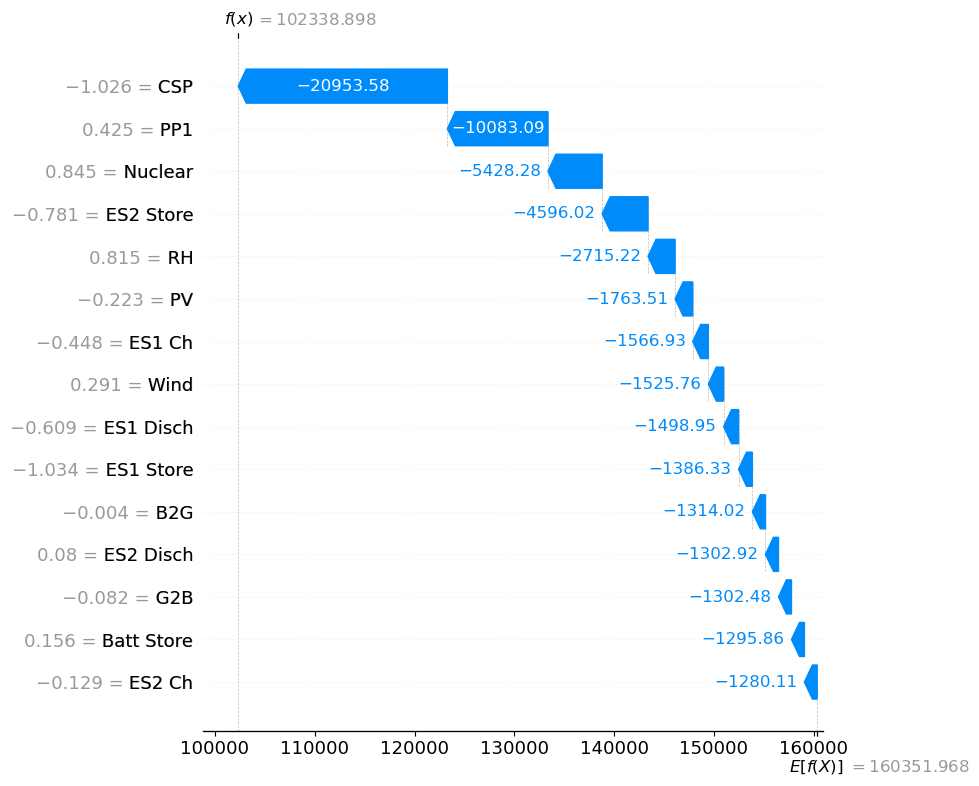

In [ ]:

y_data = y1_data
y_train = y1_train
y_test = y1_test

# Ensure X_data is a DataFrame with proper feature names
if not isinstance(X_data, pd.DataFrame):
    X_data = pd.DataFrame(X_data)

# Convert feature names to strings if they are not already
X_data.columns = [str(col) for col in X_data.columns]


model_y1 = SVR(C= 938266.6722022587, epsilon= 7.634680062462178, kernel= 'rbf', degree= 4, gamma= 0.00877730291334558)
model_y1.fit(X_train, y_train)


# Compute SHAP values
explainer = shap.KernelExplainer(model_y1.predict, X_train)
shap_values = explainer(df)

# Plot the SHAP values using a waterfall plot
shap.plots.waterfall(shap_values[0], max_display=20)

 91%|==================  | 501/552 [00:12<00:01]       

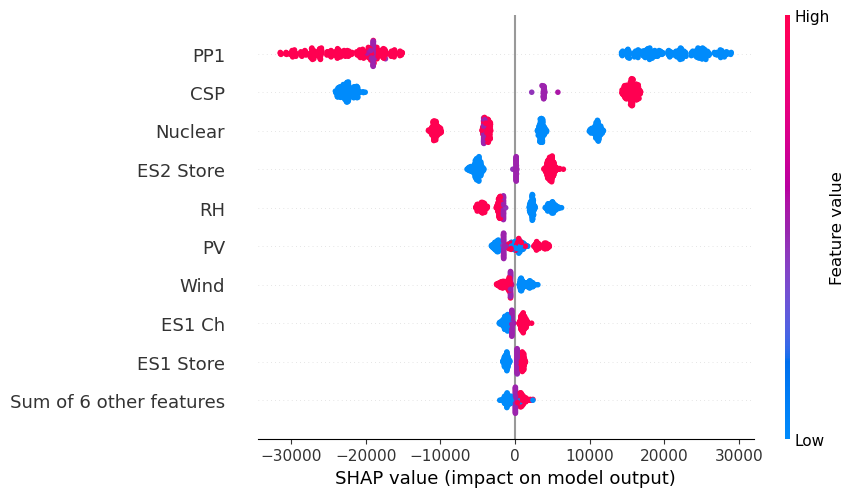

In [ ]:

y_data = y1_data
y_train = y1_train
y_test = y1_test

# Ensure X_data is a DataFrame with proper feature names
if not isinstance(X_data, pd.DataFrame):
    X_data = pd.DataFrame(X_data)

# Convert feature names to strings if they are not already
X_data.columns = [str(col) for col in X_data.columns]


mod_1 = {'max_depth': 3, 'learning_rate': 0.011723269811235474, 'n_estimators': 875, 'min_child_weight': 6, 'gamma': 0.7712938662023604, 'subsample': 0.7899217905693013, 'colsample_bytree': 0.8285058920843318, 'reg_alpha': 0.6370415102229366, 'reg_lambda': 0.3197877984587, 'random_state': 560}

model_y1 = XGBRegressor(**mod_1)
model_y1.fit(X_train, y_train)


# Compute SHAP values
explainer = shap.Explainer(model_y1, X_train)
shap_values = explainer(X_data)

# Plot the SHAP values using a waterfall plot
shap.plots.beeswarm(shap_values)

Using 552 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/1 [00:00<?, ?it/s]

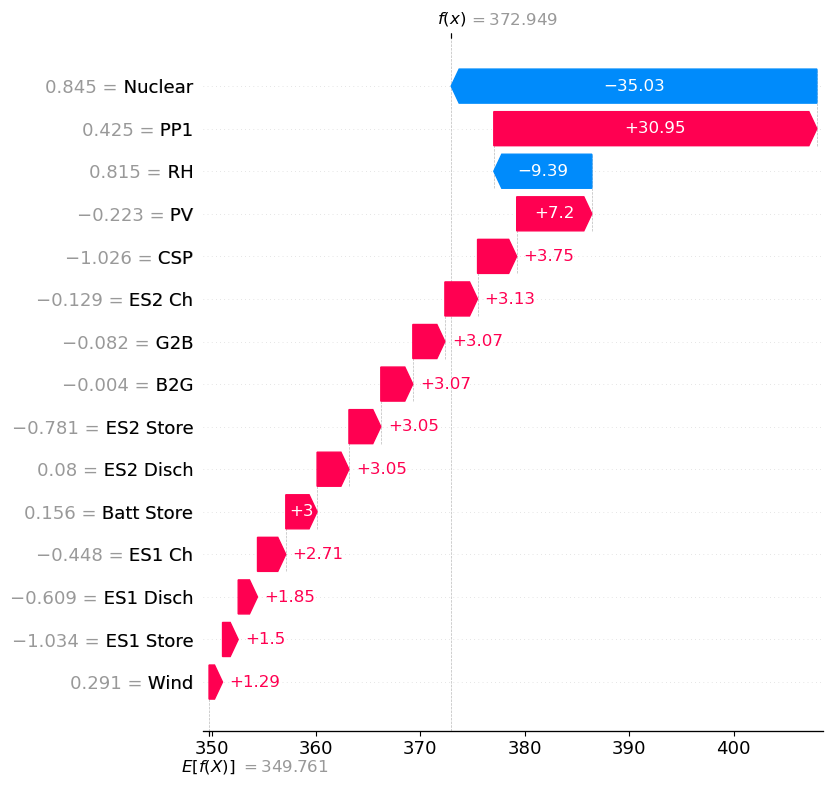

In [ ]:

y_data = y2_data
y_train = y2_train
y_test = y2_test

# Ensure X_data is a DataFrame with proper feature names
if not isinstance(X_data, pd.DataFrame):
    X_data = pd.DataFrame(X_data)

# Convert feature names to strings if they are not already
X_data.columns = [str(col) for col in X_data.columns]


model_y2 = SVR(C= 71459.276928581, epsilon= 0.9031869098259523, kernel= 'rbf', degree= 1, gamma= 0.0035901390986543542)
model_y2.fit(X_train, y_train)



# Compute SHAP values
explainer = shap.KernelExplainer(model_y2.predict, X_data)
shap_values = explainer(df)

# Plot the SHAP values using a waterfall plot
shap.plots.waterfall(shap_values[0], max_display=20)

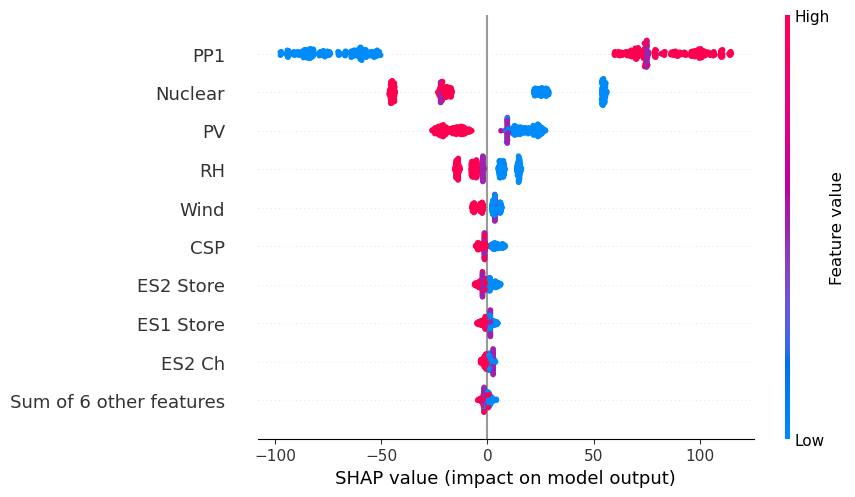

In [ ]:

y_data = y2_data
y_train = y2_train
y_test = y2_test

# Ensure X_data is a DataFrame with proper feature names
if not isinstance(X_data, pd.DataFrame):
    X_data = pd.DataFrame(X_data)

# Convert feature names to strings if they are not already
X_data.columns = [str(col) for col in X_data.columns]

mod_2 = {'max_depth': 3, 'learning_rate': 0.7866691318932307, 'n_estimators': 565, 'min_child_weight': 7, 'gamma': 0.9416813016248271, 'subsample': 0.9492401329994024, 'colsample_bytree': 0.9677794380528386, 'reg_alpha': 0.18569042405228248, 'reg_lambda': 0.8638844510641983, 'random_state': 666}

model_y2 = XGBRegressor(**mod_2)
model_y2.fit(X_train, y_train)

# Compute SHAP values
explainer = shap.Explainer(model_y2, X_data)
shap_values = explainer(X_data)

# Plot the SHAP values using a waterfall plot
shap.plots.beeswarm(shap_values)

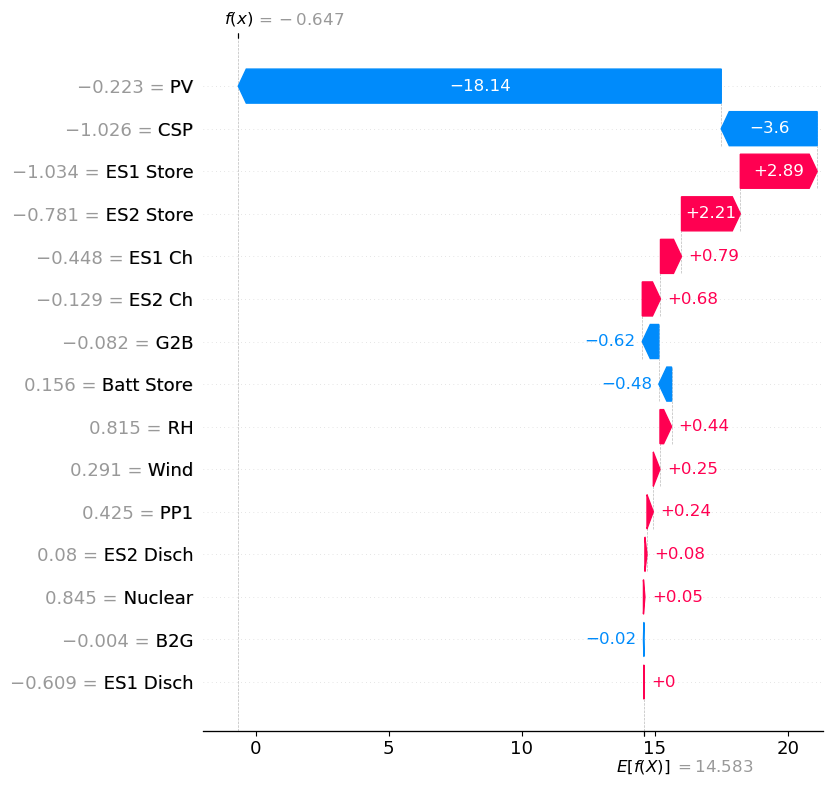

In [ ]:

y_data = y3_data
y_train = y3_train
y_test = y3_test

# Import necessary libraries
import shap
from xgboost import XGBRegressor
import pandas as pd

# Ensure X_data is a DataFrame with proper feature names
if not isinstance(X_data, pd.DataFrame):
    X_data = pd.DataFrame(X_data)

# Convert feature names to strings if they are not already
X_data.columns = [str(col) for col in X_data.columns]

# Define the parameters for the XGBRegressor
y3_params = {
    'max_depth': 5,
    'learning_rate': 0.21192829865979532,
    'n_estimators': 513,
    'min_child_weight': 1,
    'gamma': 0.8354449115144676,
    'subsample': 0.8559761007878783,
    'colsample_bytree': 0.9499990399914706,
    'reg_alpha': 0.061420625912146976,
    'reg_lambda': 0.9727616243556757,
    'random_state': 599
}

# Fit the model
model_y3 = XGBRegressor(**y3_params)
model_y3.fit(X_data, y_data)

mm = [-0.08204877,  0.15594775, -0.00367291,  0.4247027,   0.84494347,  0.29067574,
 -0.22331748,  0.815149,   -1.02562235, -0.44830675, -0.60883313, -1.03435034,
 -0.12881452,  0.08031999, -0.78065315]

# Compute SHAP values
explainer = shap.Explainer(model_y3, X_data)
shap_values = explainer(df)

# Plot the SHAP values using a waterfall plot
shap.plots.waterfall(shap_values[0], max_display=20)


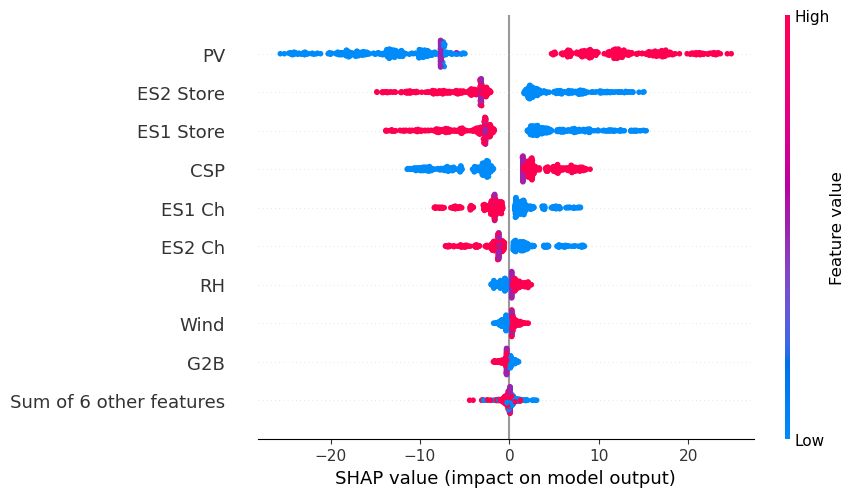

In [ ]:

y_data = y3_data
y_train = y3_train
y_test = y3_test

# Import necessary libraries
import shap
from xgboost import XGBRegressor
import pandas as pd

# Ensure X_data is a DataFrame with proper feature names
if not isinstance(X_data, pd.DataFrame):
    X_data = pd.DataFrame(X_data)

# Convert feature names to strings if they are not already
X_data.columns = [str(col) for col in X_data.columns]

# Define the parameters for the XGBRegressor
y3_params = {
    'max_depth': 5,
    'learning_rate': 0.21192829865979532,
    'n_estimators': 513,
    'min_child_weight': 1,
    'gamma': 0.8354449115144676,
    'subsample': 0.8559761007878783,
    'colsample_bytree': 0.9499990399914706,
    'reg_alpha': 0.061420625912146976,
    'reg_lambda': 0.9727616243556757,
    'random_state': 599
}

# Fit the model
model_y3 = XGBRegressor(**y3_params)
model_y3.fit(X_data, y_data)


# Compute SHAP values
explainer = shap.Explainer(model_y3, X_data)
shap_values = explainer(X_data)

# Plot the SHAP values using a waterfall plot
shap.plots.beeswarm(shap_values)


Using 386 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/1 [00:00<?, ?it/s]

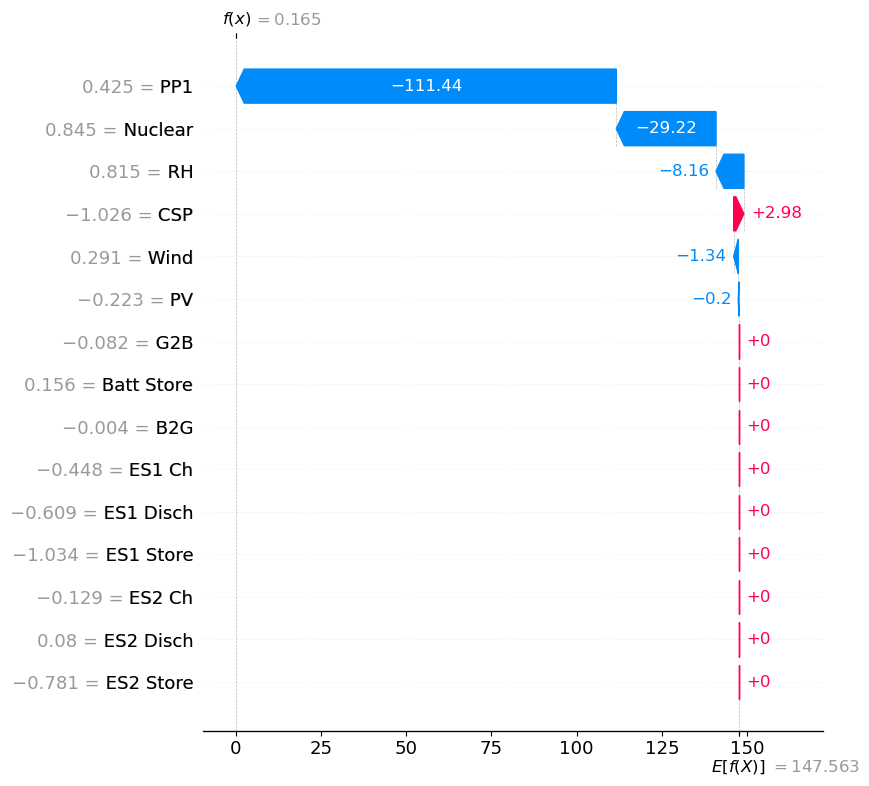

In [ ]:

y_data = y4_data
y_train = y4_train
y_test = y4_test

# Ensure X_data is a DataFrame with proper feature names
if not isinstance(X_data, pd.DataFrame):
    X_data = pd.DataFrame(X_data)

# Convert feature names to strings if they are not already
X_data.columns = [str(col) for col in X_data.columns]


y4_params = {'C': 435707.8208868281, 'epsilon': 0.25793769392540933, 'kernel': 'rbf', 'degree': 4, 'gamma': 0.0048393326352296085}
model_y4 = MLPRegressor(hidden_layer_sizes=(7, 28, 23, 19), activation='relu', alpha=0.9365945996054417, solver='lbfgs', random_state=72)
model_y4.fit(X_train, y_train)


# Compute SHAP values
explainer = shap.KernelExplainer(model_y4.predict, X_train)
shap_values = explainer(df)

# Plot the SHAP values using a waterfall plot
shap.plots.waterfall(shap_values[0], max_display=20)

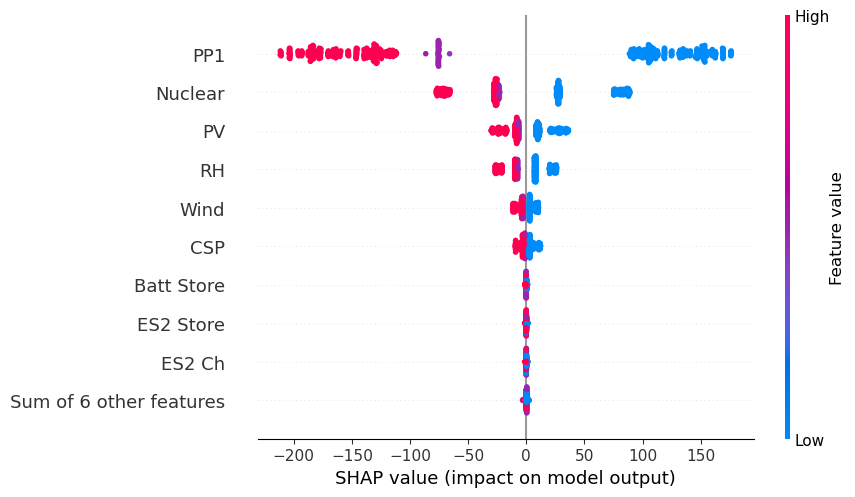

In [ ]:

y_data = y4_data
y_train = y4_train
y_test = y4_test

# Ensure X_data is a DataFrame with proper feature names
if not isinstance(X_data, pd.DataFrame):
    X_data = pd.DataFrame(X_data)

# Convert feature names to strings if they are not already
X_data.columns = [str(col) for col in X_data.columns]


mod_4 = {'max_depth': 10, 'learning_rate': 0.31195099027474943, 'n_estimators': 120, 'min_child_weight': 8, 'gamma': 0.5887647311991991, 'subsample': 0.8053950657222284, 'colsample_bytree': 0.9531753908252204, 'reg_alpha': 0.9543398120967802, 'reg_lambda': 0.05317709105394063, 'random_state': 693}

model_y4 = XGBRegressor(**mod_4)
model_y4.fit(X_train, y_train)


# Compute SHAP values
explainer = shap.Explainer(model_y4, X_data)
shap_values = explainer(X_data)

# Plot the SHAP values using a waterfall plot
shap.plots.beeswarm(shap_values)